# Universal adversarial attacks (based on [paper](https://arxiv.org/abs/1709.03582))

## Intro

Suppose we have some classification model $f: X \to Y$ which takes vector $x \in \mathbb{R^n}$ and output some label $y$. It appears that deep neural networks are valunable to small imperceptible perturbations called adversarial attacks. Formally, an adversarial attack is the verctor $\varepsilon \in \mathbb{R^n}$ that leads to misclassification: $y(x) \neq y(x + \varepsilon)$.

<img src="https://openai.com/content/images/2017/02/adversarial_img_1.png" style="display=block; margin:auto">

However, it was shown that there exist universal adversarial perturbations: $\varepsilon \in \mathbb{R^n}$ that leads to misclassification $y(x) \neq y(x + \varepsilon)$ for most of inputs.

The hypetesis is that perturbation of a hidden layer caused by an attack will propagate further in the network changing predicted label of x.

Let $f_i$ be the output of $i$-s hidden layer, then
$$f_i(x + \varepsilon) - f_i(x) \approx J_i(x)\varepsilon$$
So, to find attack we need to solve the following optimization problem
$$
\max_{\|\varepsilon\|_p = 1} \sum\limits_{x \in \text{batch}}\|J_i(x)\varepsilon\|_q^q
$$

## Problem discription

+ Obtain fixed point iteration to solve the problem above using first order optimality condition. **(5 pts)**    
Note that monotinicity of $\left( \cdot \right)^q$ allows us to ignore it and optimize 
$$
\max_{\|\varepsilon\|_p = 1} \|J_i(X)\varepsilon\|_q, \; X = (x_1, \dots, x_B), x_j \in  \text{batch} \Leftrightarrow \\ \Leftrightarrow
\max_{\varepsilon} \frac{\|J_i(X)\varepsilon\|_q}{\|\varepsilon\|_p}
$$ 
instead. Following [Boyd 1974](https://www.sciencedirect.com/science/article/pii/0024379574900299), gradient is
$$
\frac{\partial_j \|x\|_p}{\partial x_j} =
\frac{\partial_j }{\partial x_j} \left(\sum_i |x_i|^p\right)^{\frac{1}{p}}=
\frac{1}{p}\left(\sum_i |x_i|^p\right)^{\frac{1}{p}-1}
\sum_i p |x_i|^{p-1} \frac{\partial |x_i|}{\partial x_j} = \\ =
\left[\left(\sum_i |x_i|^p\right)^{\frac{1}{p}}\right]^{1-p}
\sum_i |x_i|^{q-1} \delta_{ij} \text{sgn}(x_i) = 
\|x\|_p^{1-p}|x_j|^{p-1} \text{sgn}(x_j); \; \\
\nabla \|x\|_p = \|x\|_p^{1-p}\underbrace{|x|^{p-1} \text{sgn}(x)}_{\psi_p(x)};\\
\nabla_\varepsilon \sum\limits_{x \in \text{batch}}\|J_i(x)\varepsilon\|_q^q = 
\nabla_\varepsilon \frac{\|J_i(X)\varepsilon\|_q}{\|\varepsilon\|_p}= \\ =
\psi_{p^\prime} \left(\psi_{q}\left(J_i(X)\varepsilon\right)J_i(X)\right)-
 \left(\frac{\|J_i(X)\varepsilon\|_q}{\|\varepsilon\|_p}\right)^{\frac{q}{p-1}}\|\varepsilon\|_p^{\frac{q-p}{p-1}}\varepsilon = 0;
$$
Where $\frac{1}{p^\prime} + \frac{1}{p} = 1$. Thus, fixed point iteration is
$$
\varepsilon_{k+1} = \|\varepsilon_k\|_p^{\frac{q-p}{p-1}} \psi_{p^\prime} \left(\psi_{q}\left(J_i(X)\varepsilon_k\right)J_i(X)\right)
$$
We can simplify it utilizing projection on our $p$-ball, once again implying monotonicity of power operation:
$$
\varepsilon_{k+1} = \psi_{p^\prime} \left(\psi_{q}\left(J_i(X)\varepsilon_k\right)J_i(X)\right); \\
\varepsilon_{k+1} = \frac{\varepsilon_{k+1} }{\|\varepsilon_{k+1} \|_p}
$$

+ Suppose additionally that $\varepsilon$ should be sparse: $\|\varepsilon\|_0 \leq k$. Correct the algorithm above using additional truncation operator. **(5 pts)**   
Rewriting condition as maximization problem for dual norm,
$$
\max_{\|\varepsilon\|_p = 1} \|J_i(X)\varepsilon\|_q =
\max_{\varepsilon, \|y\|_p^\prime \leq 1} \|J_i(X)\varepsilon\|_q + \underbrace{\lambda(|y^T\varepsilon|-1)}_{g(\varepsilon)} + \underbrace{\mu(\|y\|_{p^\prime}-1)}_{h(y)}
$$
$$
\varepsilon_{k+1} = \psi_{p^\prime}\left( \text{trunc}_k \left[\psi_{q}\left(J_i(X)\varepsilon_k\right)J_i(X)\right]\right); \\
\varepsilon_{k+1} = \frac{\varepsilon_{k+1} }{\|\varepsilon_{k+1} \|_p}
$$
+ Implement algorithms 1 and 2. Find universal perturbations on CIFAR dataset using random batch of size 64. Report fooling rate depending on hyperparameters **(8 pts)**
$$
\text{FoolingRate} = \frac{1}{N}\sum\limits_{i = 1}^N \mathbb{1}[y(x + \varepsilon) \neq y(x)]
$$



In [1]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'
from tqdm.notebook import tqdm

plt.rcParams["figure.figsize"] = (10, 8)
fontsize = 14

import scipy
from scipy import sparse, linalg

In [2]:
import torch
import torch.nn as nn
import requests

In [3]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params={"id": id}, stream=True)
    token = get_confirm_token(response)

    if token:
        params = {"id": id, "confirm": token}
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)


def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith("download_warning"):
            return value

    return None


def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

In [4]:
class CifarNet(nn.Module):
    def __init__(self):
        super(CifarNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)

        self.pool = nn.MaxPool2d(2, 2)

        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(3200, 256)

        self.dropout = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)

        self.net = [
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.pool,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.pool,
            nn.Flatten(),
            self.fc1,
            self.relu,
            self.dropout,
            self.fc2,
            self.relu,
            self.fc3,
        ]

    def forward(self, x):
        out = x
        for module in self.net:
            out = module(out)
        return out

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

file_id = "1qrNvr3eLYjvbkVg5jY2sYA2rqK9XkTXs"
download_file_from_google_drive(file_id, "./cifar_checkpoint.pth")

model = CifarNet().to(device)
model.load_state_dict(torch.load("./cifar_checkpoint.pth", map_location="cpu"))

<All keys matched successfully>

In [6]:
! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary

In [8]:
dataset = torchvision.datasets.CIFAR10("./data", transform=transforms.ToTensor(), download=True)
dataset

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [10]:
imgs, labels = next(iter(dataloader))
imgs = imgs.to(next(model.parameters()).device)
summary(model, input_data=imgs)

Layer (type:depth-idx)                   Output Shape              Param #
CifarNet                                 [64, 10]                  --
├─Conv2d: 1-1                            [64, 64, 30, 30]          1,792
├─ReLU: 1-2                              [64, 64, 30, 30]          --
├─Conv2d: 1-3                            [64, 64, 28, 28]          36,928
├─ReLU: 1-4                              [64, 64, 28, 28]          --
├─MaxPool2d: 1-5                         [64, 64, 14, 14]          --
├─Conv2d: 1-6                            [64, 128, 12, 12]         73,856
├─ReLU: 1-7                              [64, 128, 12, 12]         --
├─Conv2d: 1-8                            [64, 128, 10, 10]         147,584
├─ReLU: 1-9                              [64, 128, 10, 10]         --
├─MaxPool2d: 1-10                        [64, 128, 5, 5]           --
├─Linear: 1-11                           [64, 256]                 819,456
├─ReLU: 1-12                             [64, 256]              

In [11]:
def get_layer_output(x, model, i=0):
    model.eval()
    out = x
    for index in range(i):
        out = model.net[index](out)
    return out

In [12]:
i = 3
get_layer_output(imgs, model, i).shape

torch.Size([64, 64, 28, 28])

In [13]:
from torch.autograd.functional import jvp, vjp

In [14]:
Ax = jvp(lambda x: get_layer_output(x, model, i), imgs[:1], torch.zeros_like(imgs[:1]))[1]
ATx = vjp(lambda x: get_layer_output(x, model, i), imgs, torch.zeros_like(get_layer_output(imgs, model, i)))[1].sum(0)
Ax.shape, ATx.shape

(torch.Size([1, 64, 28, 28]), torch.Size([3, 32, 32]))

In [15]:
def generalized_power_method(size, matvec, rmatvec, n_iters=20, p=np.inf, q=2, truncate=0):
    def psi(x, q):
        return torch.abs(x) ** (q - 1) * torch.sign(x)

    v = torch.randn(size).to(device)
    if p == np.inf:
        v = torch.clip(v, -1, 1)
    else:
        v = v / torch.norm(v, p=p)
        p_prime = 1.0 / (1.0 - 1.0 / p)
    for i in tqdm(range(n_iters)):
        Av = matvec(v)
        v = rmatvec(psi(Av, q))
        if truncate:
            _, indices = torch.topk(torch.abs(v).view(-1), size - truncate, largest=False)
            v.view(-1)[indices] = 0
        if p == np.inf:
            v = torch.clip(v, -1, 1)
        else:
            v = psi(v, p_prime)
            v = v / torch.norm(v, p=p)
    s = torch.norm(matvec(v), p=q)
    return v, s


def generate_universal_perturbation(batch, layers, n_iters=20, p=10, q=2, k=0):
    m, n = layers(batch).shape, batch[:1].shape  # Bxhidden_dims, 1xCxHxW

    def dnn_matvec(v):
        matvecs = []
        for x in batch:
            matvecs.append(jvp(layers, x.unsqueeze(0), v.view(n))[1])
        return torch.cat(matvecs)

    def dnn_rmatvec(v):
        return vjp(layers, batch, v)[1].sum(0)

    adv, s = generalized_power_method(batch[0].numel(), dnn_matvec, dnn_rmatvec, n_iters, p, q, k)
    return adv / torch.norm(adv, p=p), s

In [16]:
perturbations = {}

for i in range(len(model.net)):
    adv, s = generate_universal_perturbation(imgs, lambda x: get_layer_output(x, model, i), 100, np.inf, 10)
    perturbations[i] = {"adv": adv, "s": s}

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

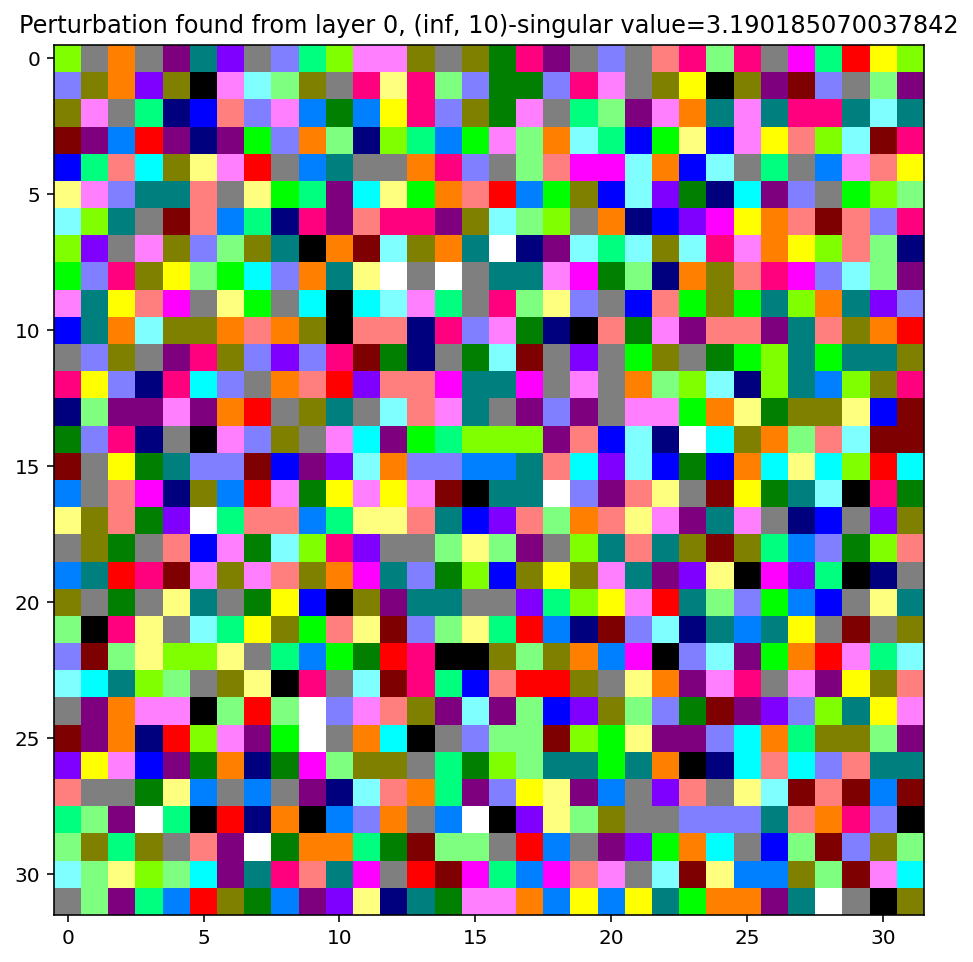

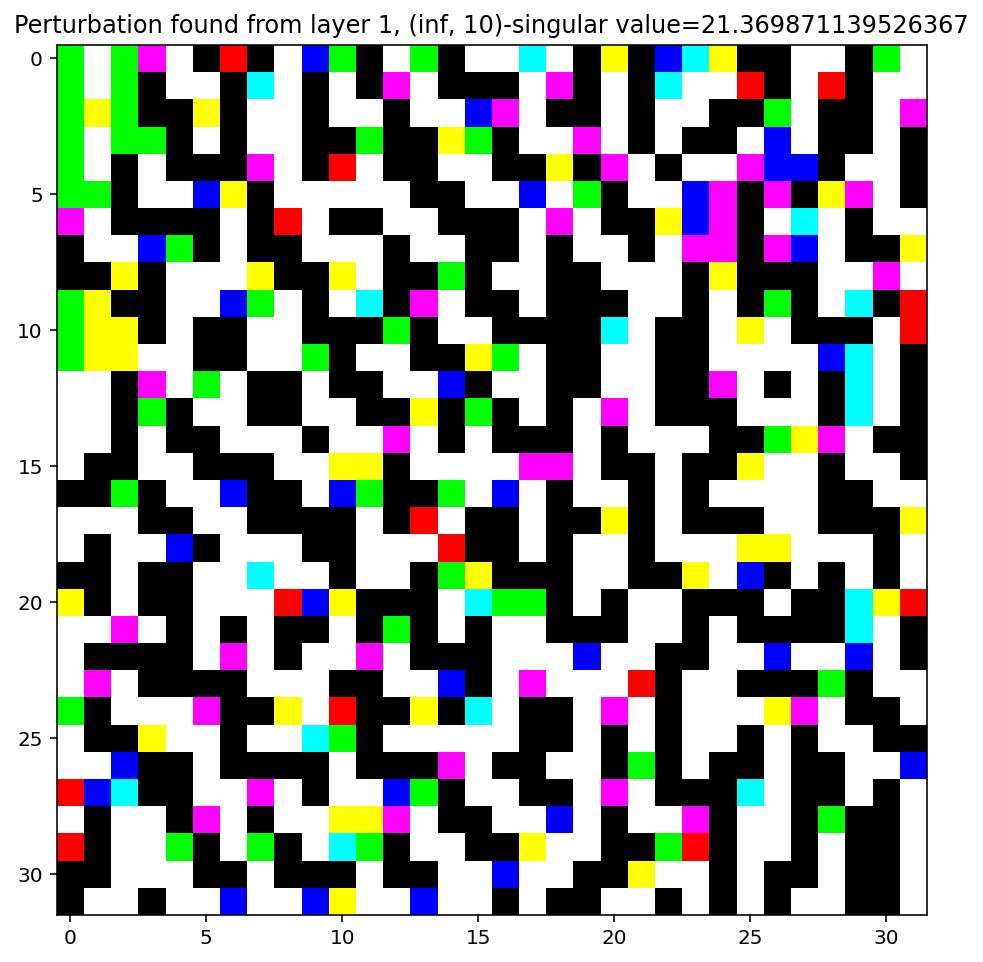

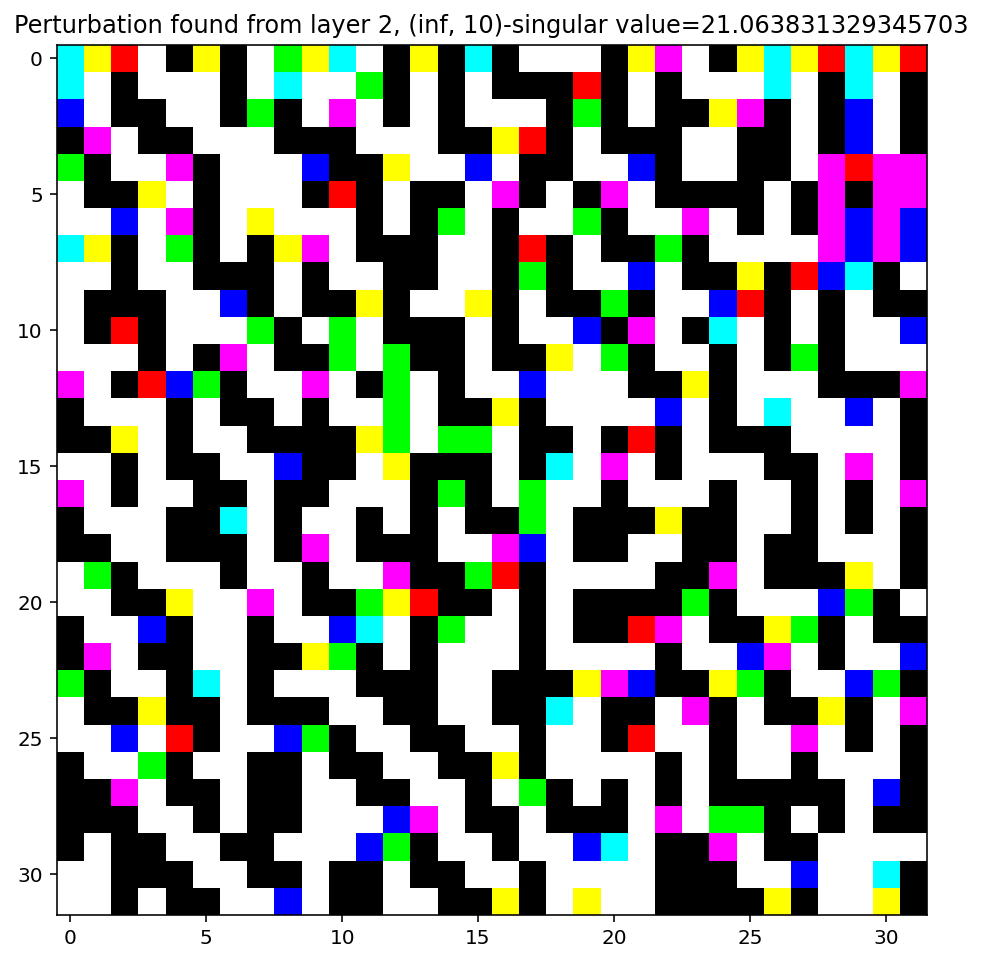

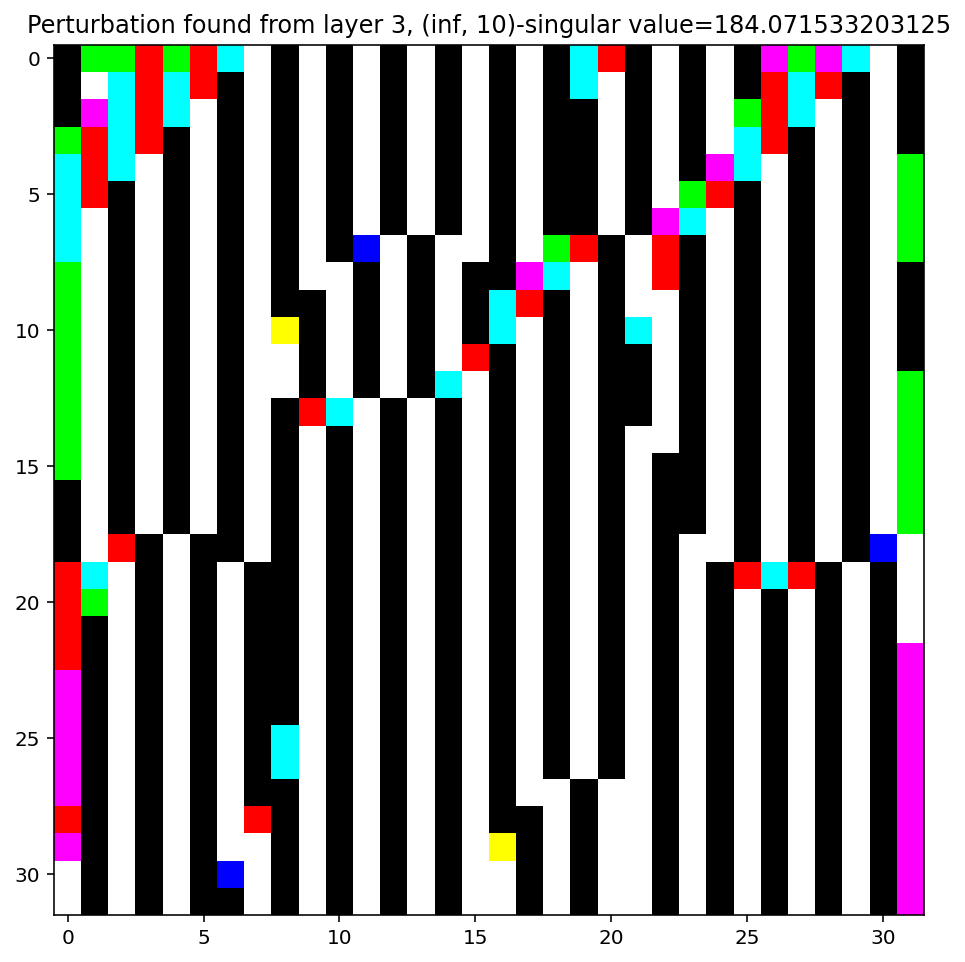

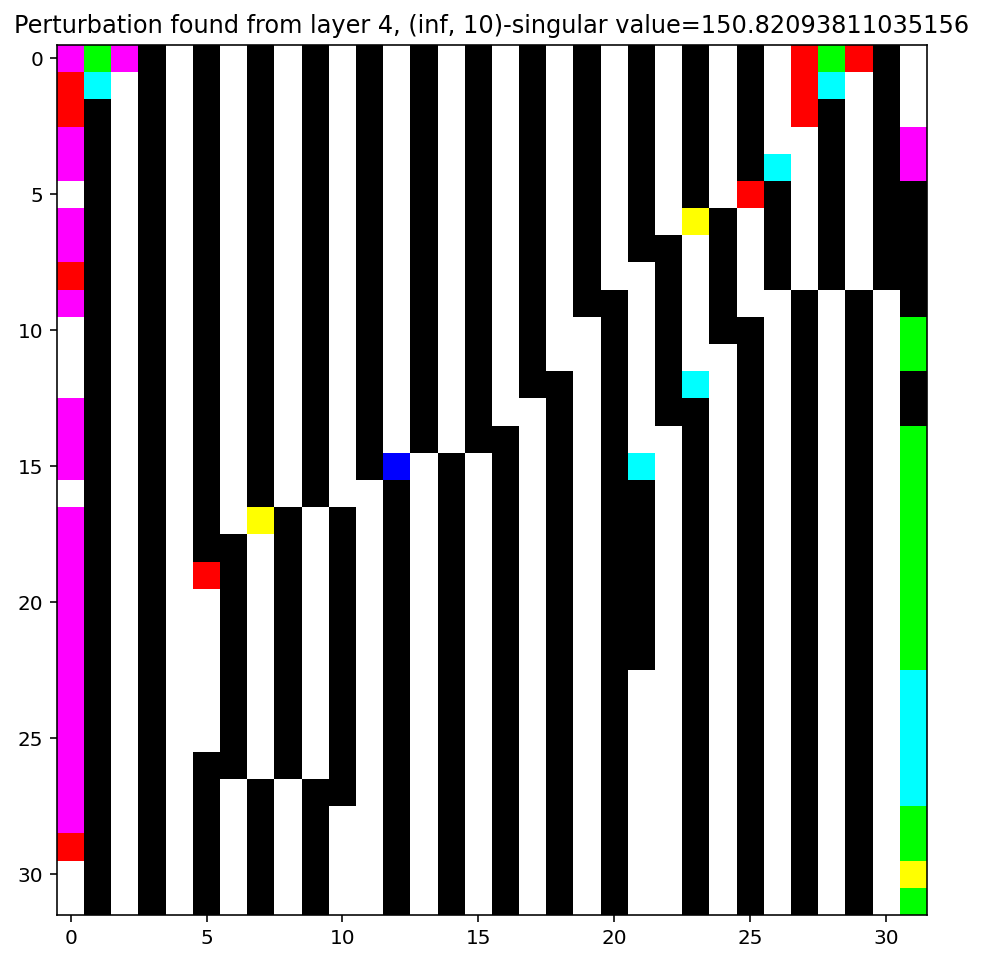

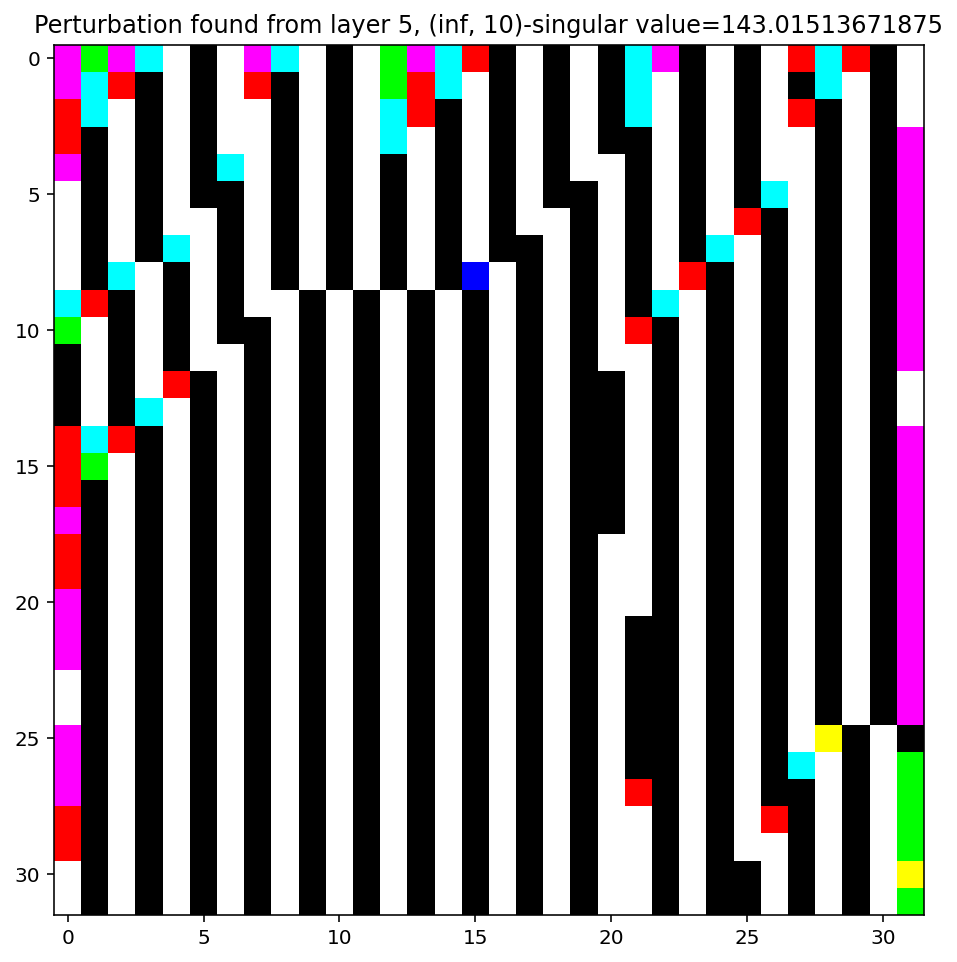

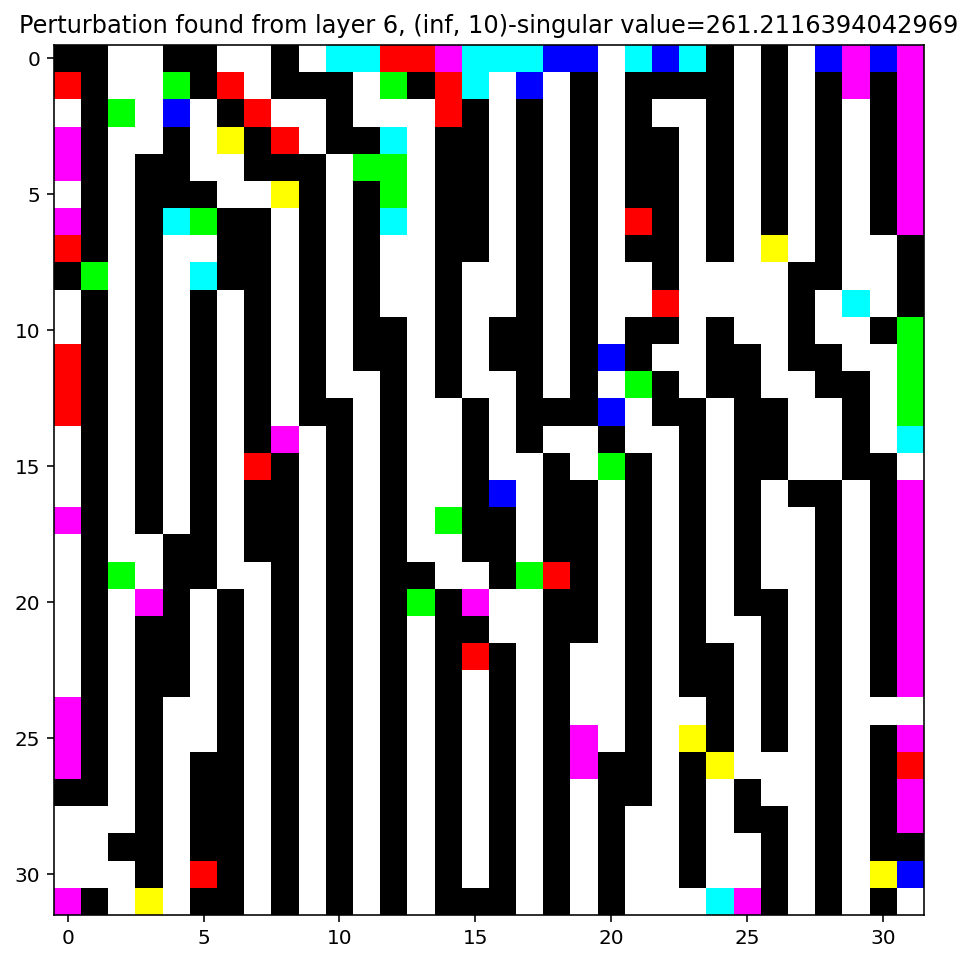

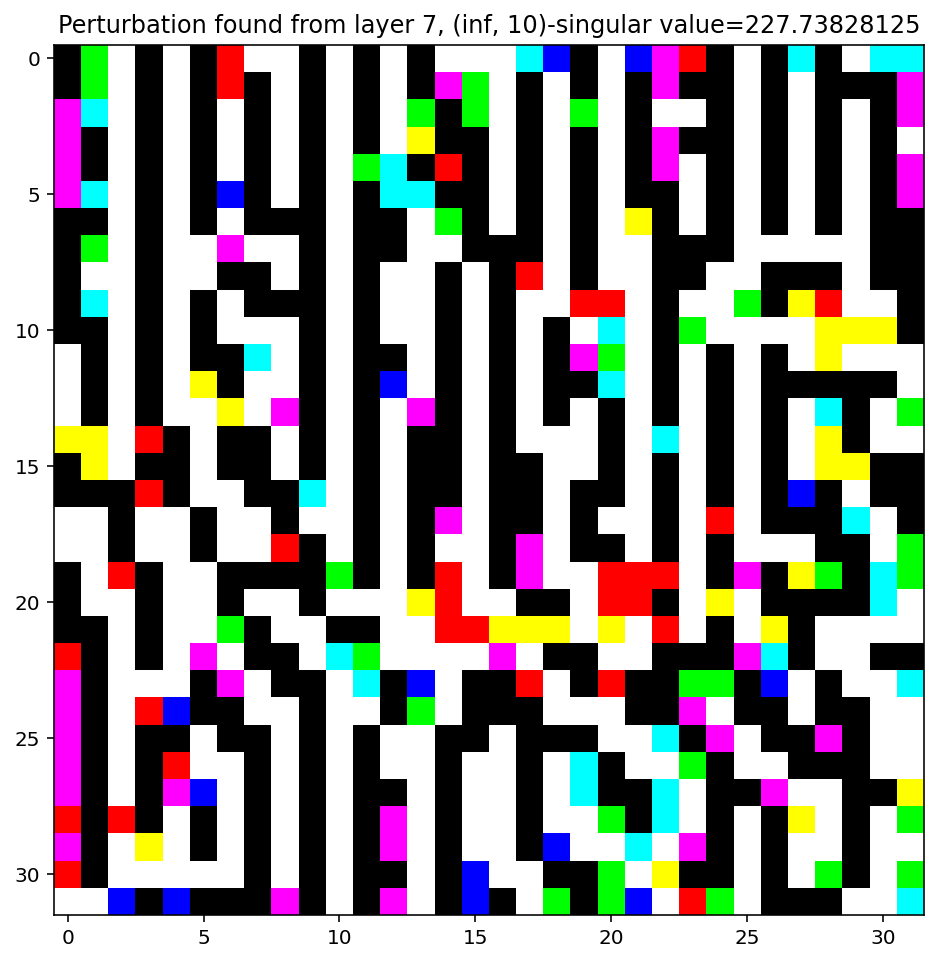

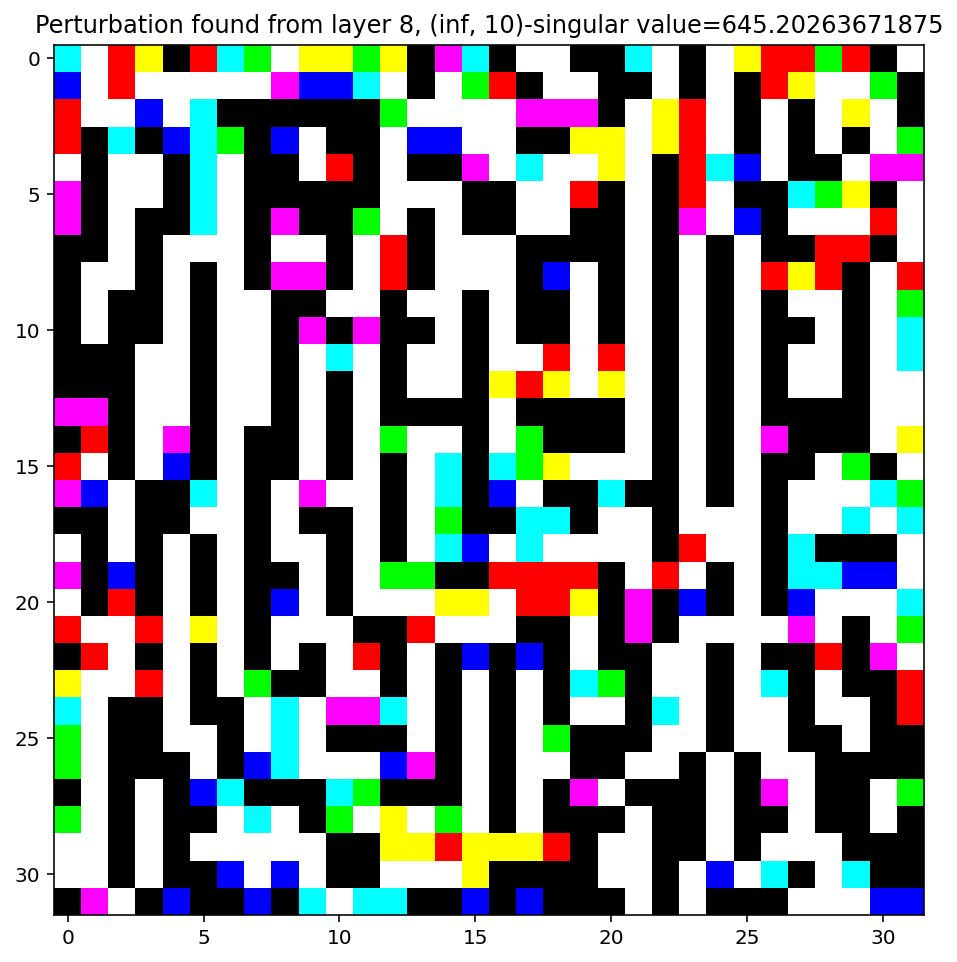

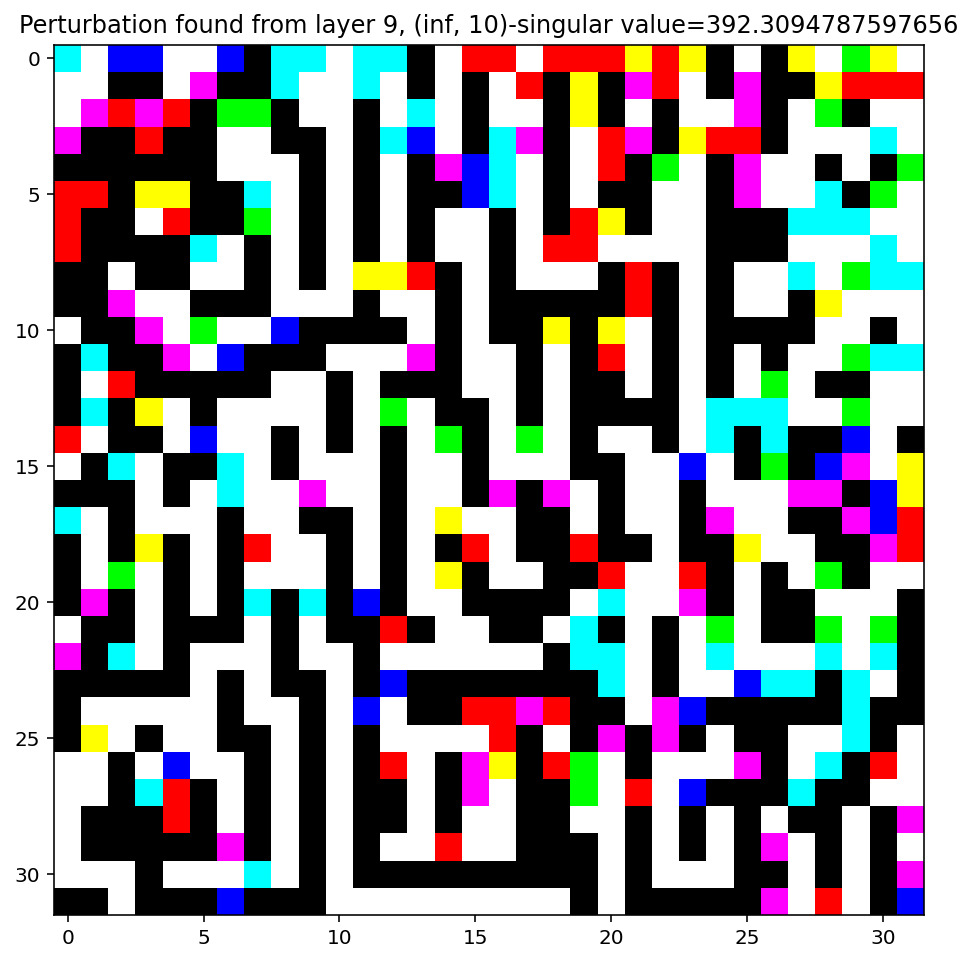

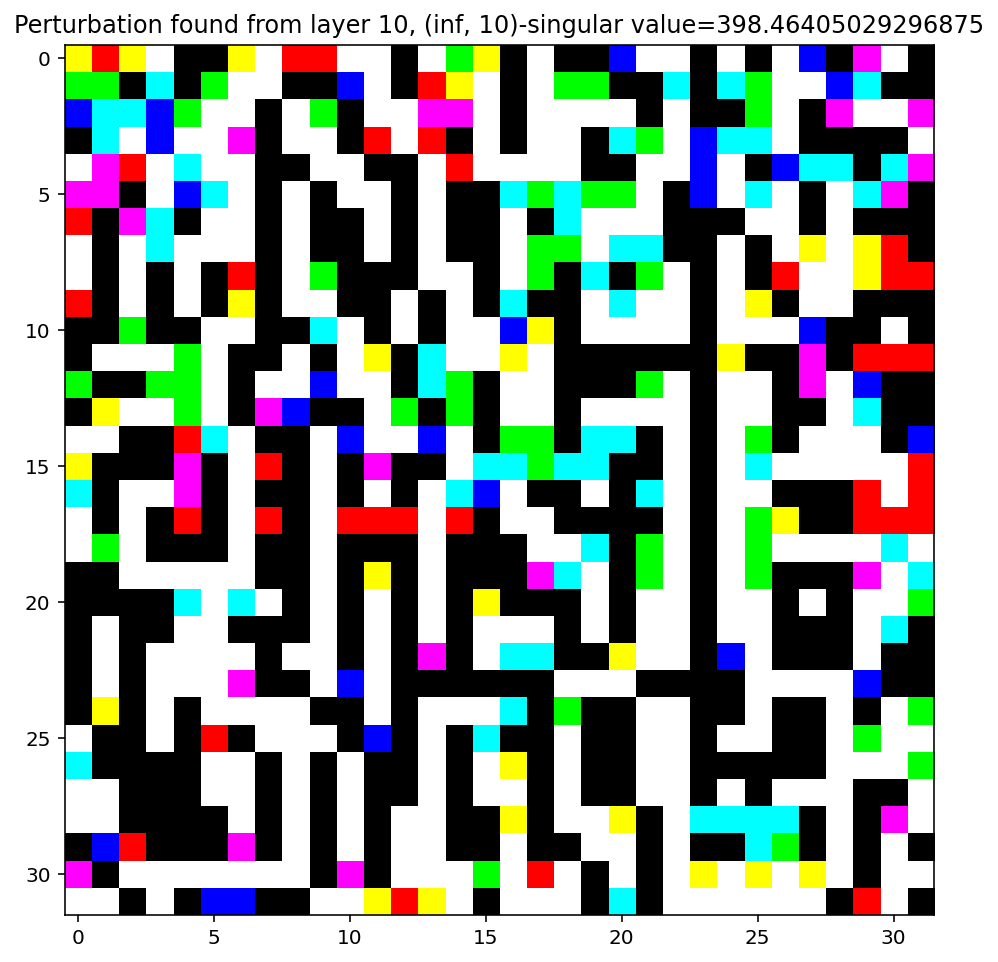

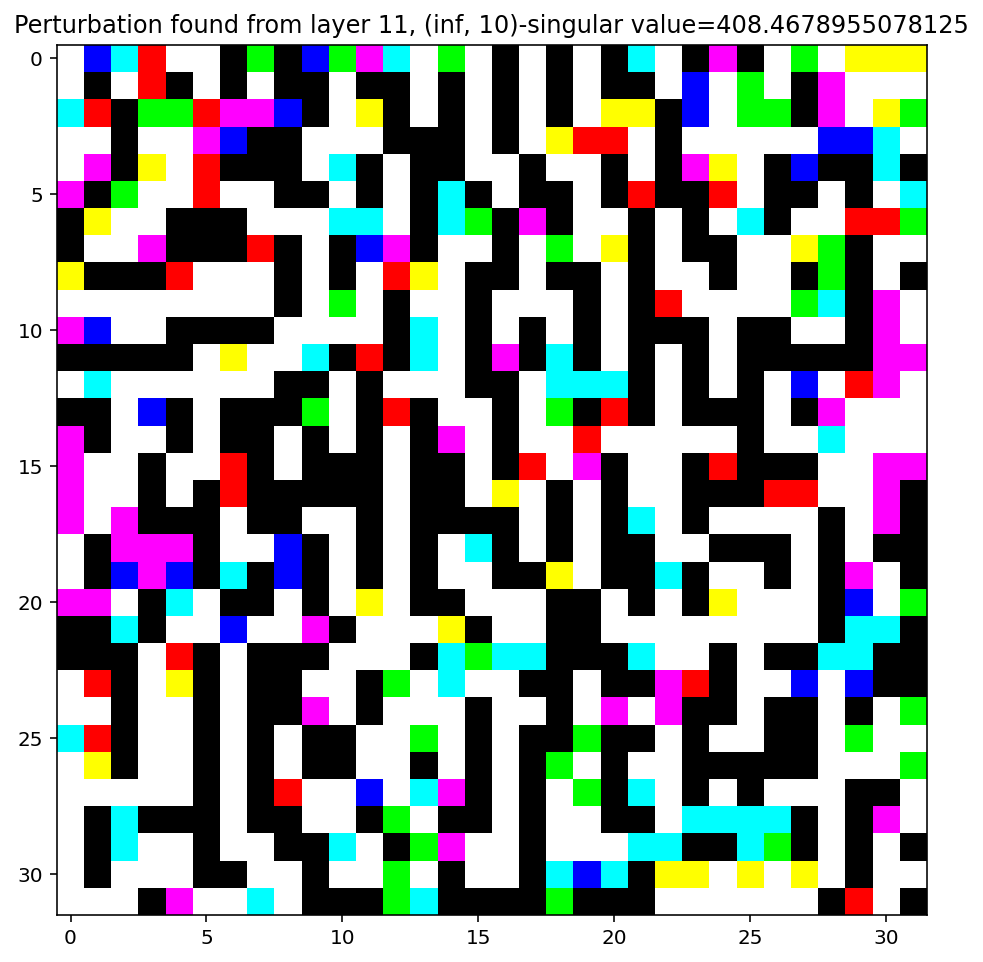

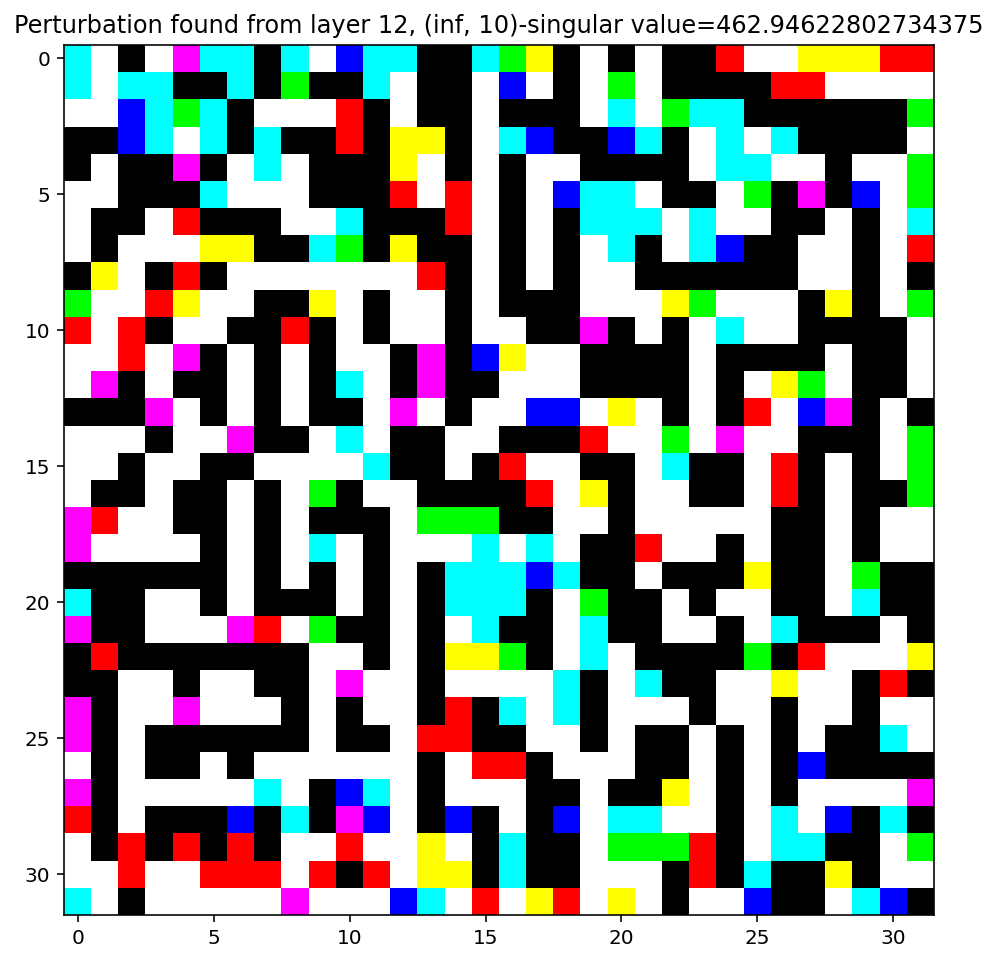

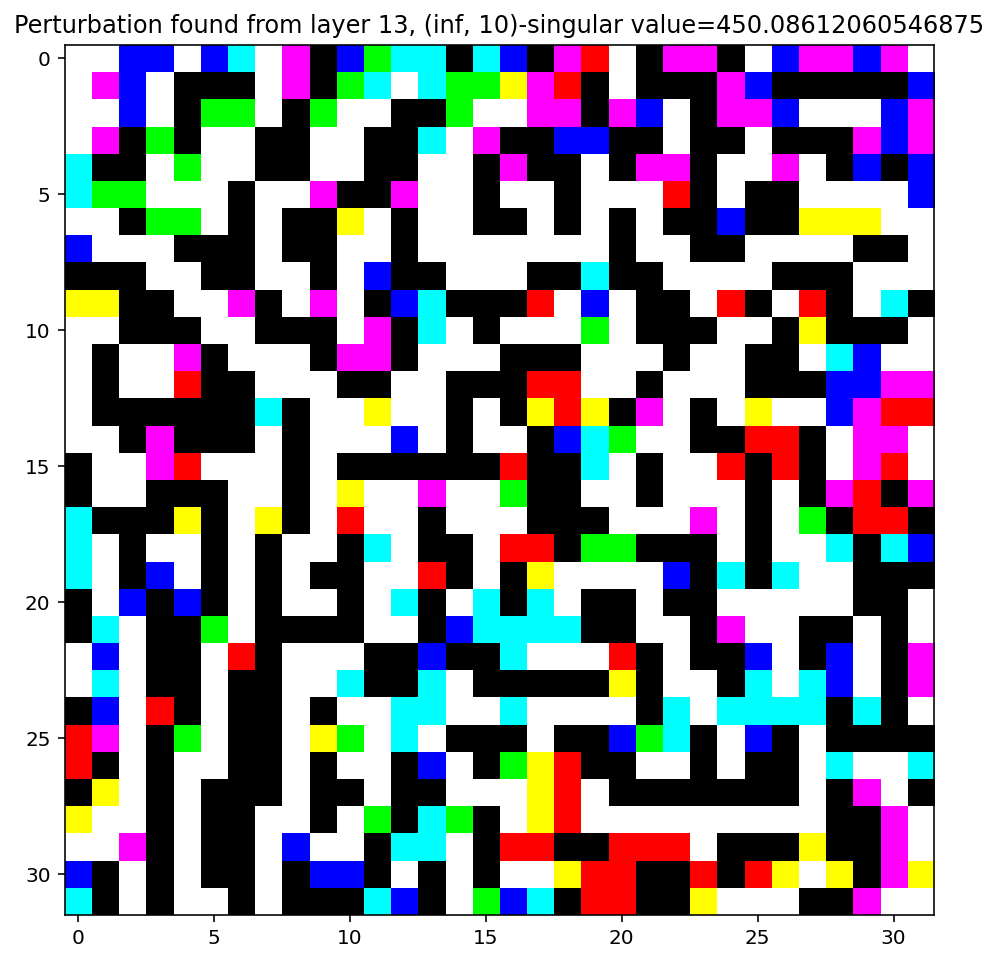

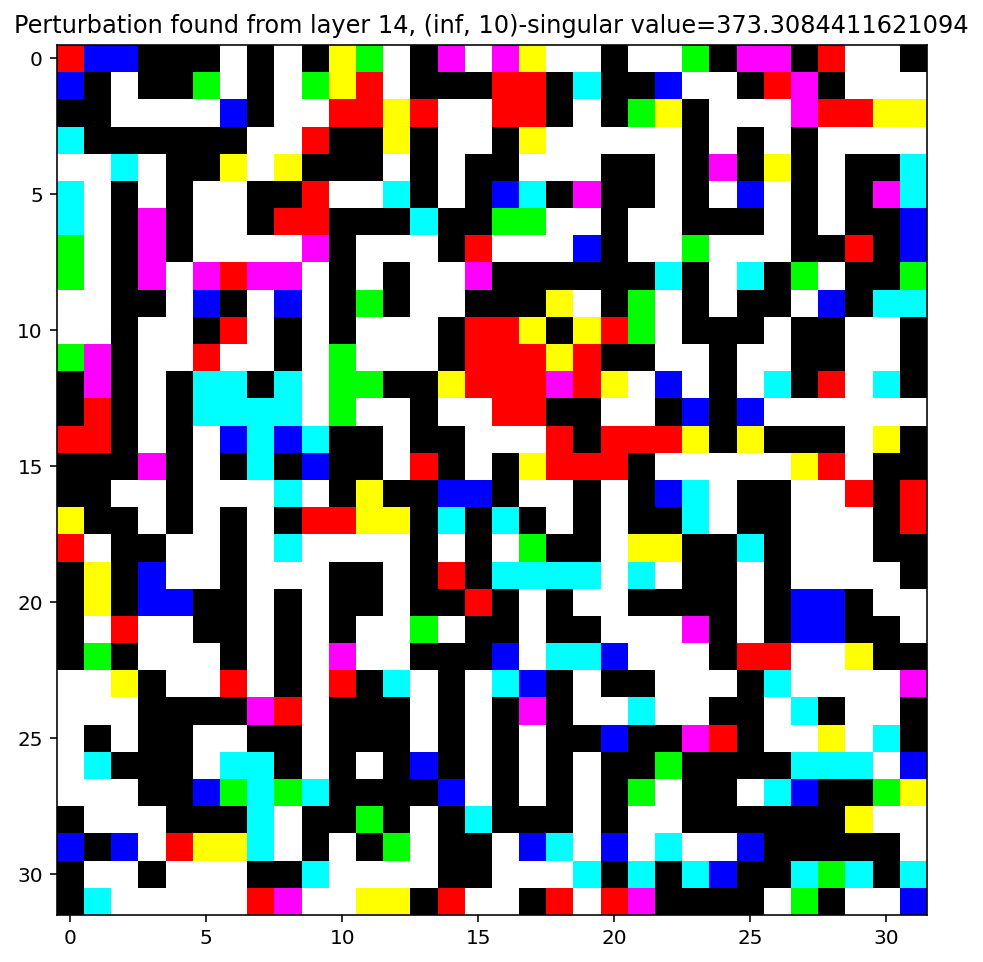

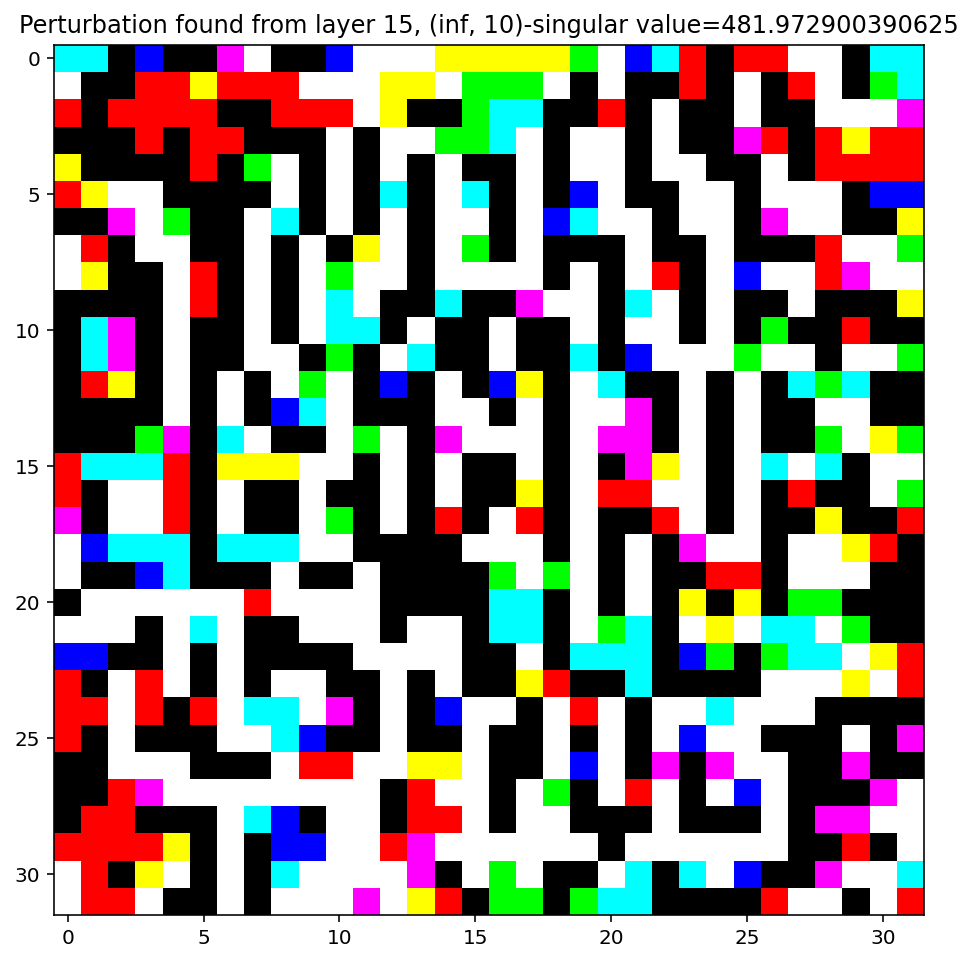

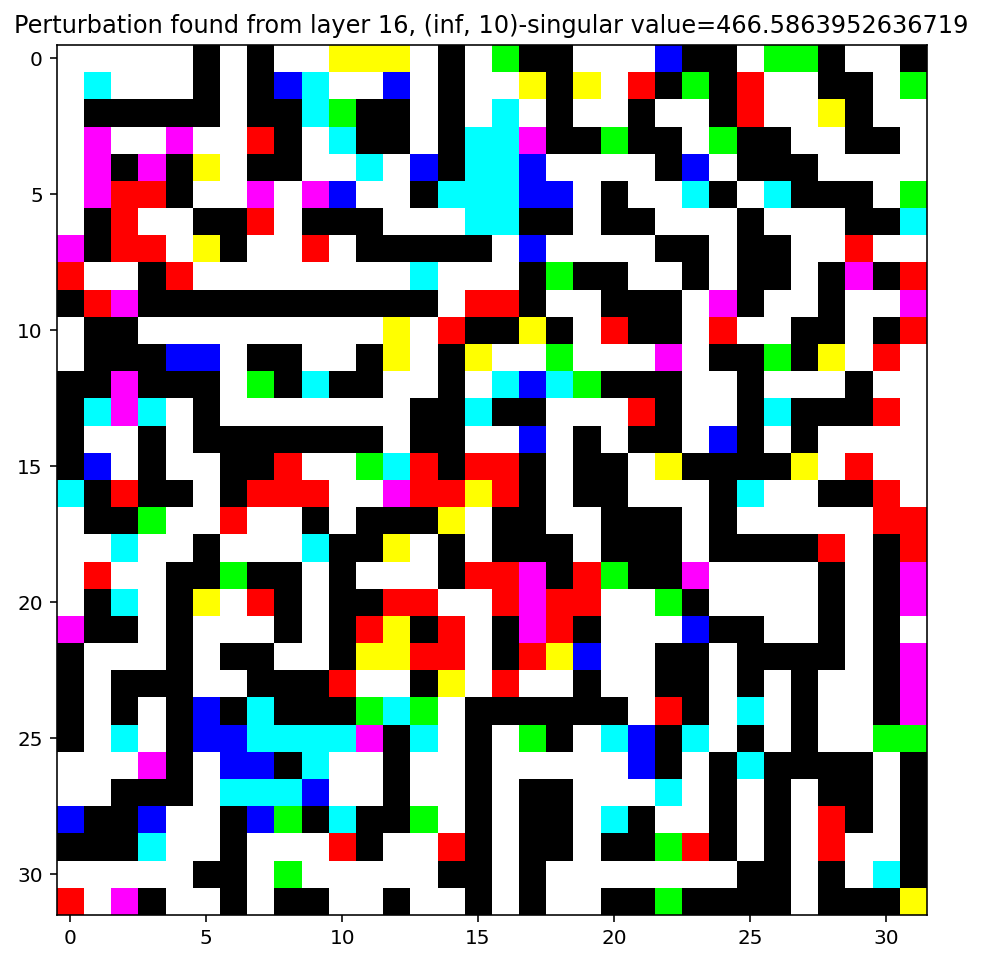

In [17]:
for index, perturb in perturbations.items():
    plt.title(f"Perturbation found from layer {index}, (inf, 10)-singular value={perturb['s']}")
    plt.imshow((0.5 + 0.5 * perturb["adv"]).permute(1, 2, 0).detach().cpu().numpy())
    plt.show()

In [18]:
sigmas = [p["s"].detach().cpu().numpy() for i, p in sorted(perturbations.items())]
np.argsort(sigmas)[::-1]

array([ 8, 15, 16, 12, 13, 11, 10,  9, 14,  6,  7,  3,  4,  5,  1,  2,  0])

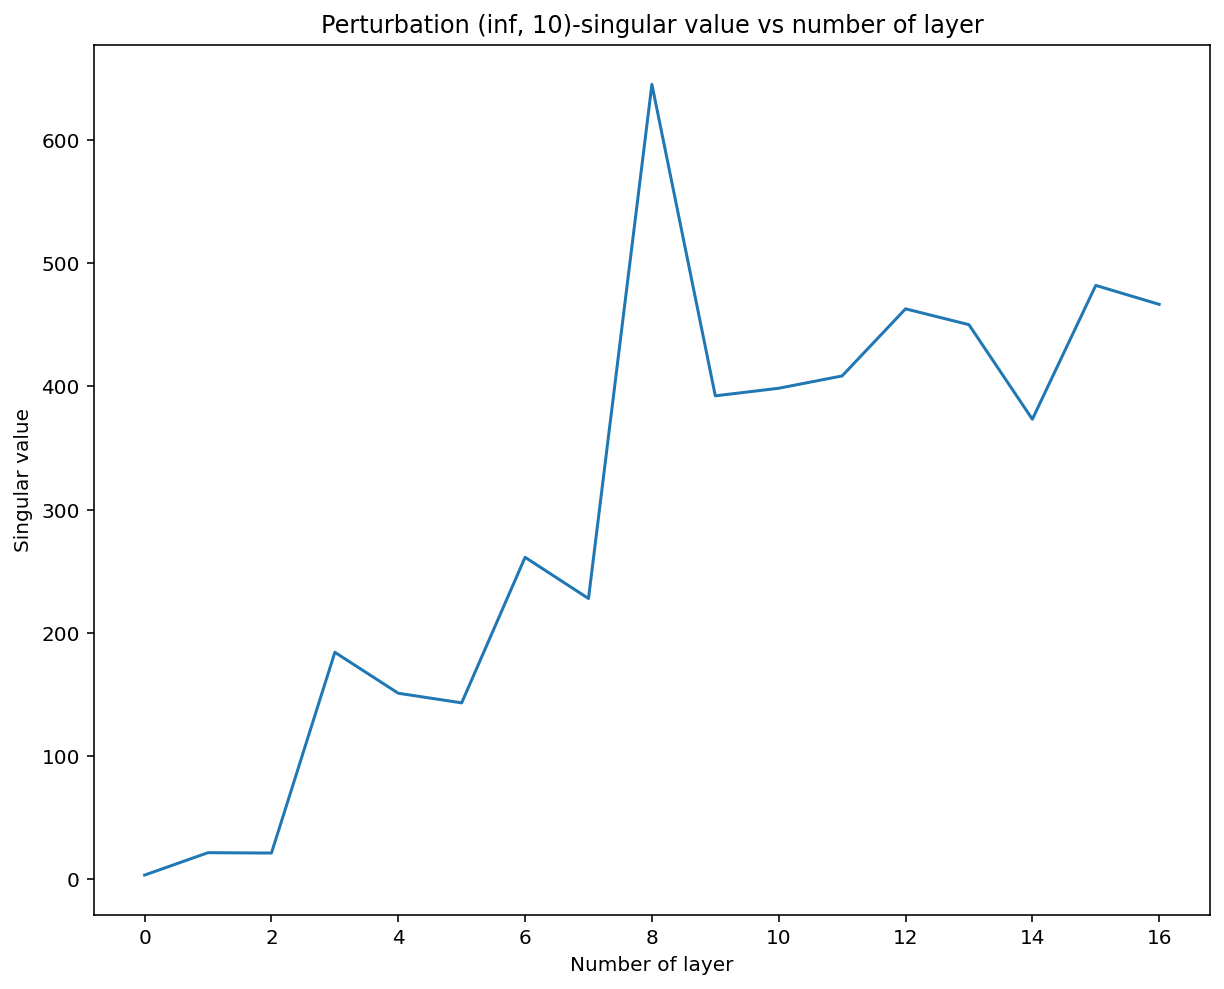

In [19]:
plt.title(f"Perturbation (inf, 10)-singular value vs number of layer")
plt.xlabel("Number of layer")
plt.ylabel("Singular value")
plt.plot(sigmas)
plt.show()

In [20]:
def get_fooling_rate(model, dataloader, adv, alpha=0.15):
    adv = adv.to(next(model.parameters()).device)
    rate = 0.0
    model.eval()
    N = 0
    for i, (imgs, labels) in enumerate(dataloader):
        if i == 0:
            continue
        with torch.no_grad():
            imgs = imgs.to(next(model.parameters()).device)
            labels = labels.to(next(model.parameters()).device)
            pred_labels = model(imgs).argmax(-1)
            fool_labels = model(imgs + alpha * adv).argmax(-1)
        rate += (pred_labels != fool_labels).sum()
        N += len(pred_labels)
    return rate.detach().cpu().numpy() / N

In [21]:
for index in tqdm(perturbations.keys()):
    perturbations[index]["rate"] = get_fooling_rate(model, dataloader, perturbations[index]["adv"])

  0%|          | 0/17 [00:00<?, ?it/s]

In [22]:
rates = [p["rate"] for i, p in sorted(perturbations.items())]
np.argsort(rates)[::-1]

array([ 5,  3,  4,  6, 10,  2,  8, 16,  1,  9, 11, 12, 14, 15, 13,  7,  0])

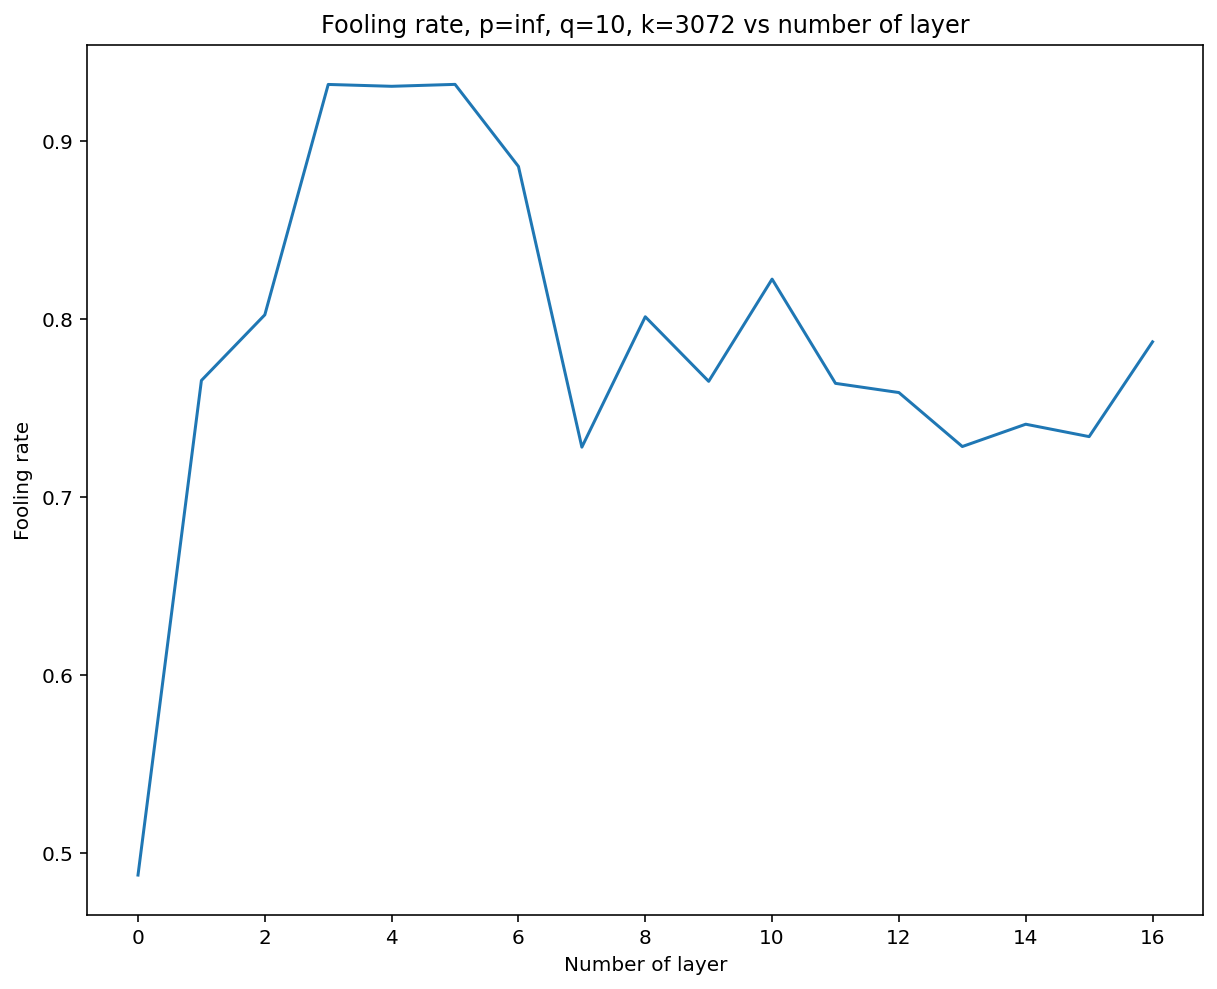

In [23]:
plt.title(f"Fooling rate, p=inf, q=10, k=3072 vs number of layer")
plt.xlabel("Number of layer")
plt.ylabel("Fooling rate")
plt.plot(rates)
plt.show()

In [24]:
i = 4
p = np.inf
q = 5
k = 1500
adv, s = generate_universal_perturbation(imgs, lambda x: get_layer_output(x, model, i), 100, p, q, k)

  0%|          | 0/100 [00:00<?, ?it/s]

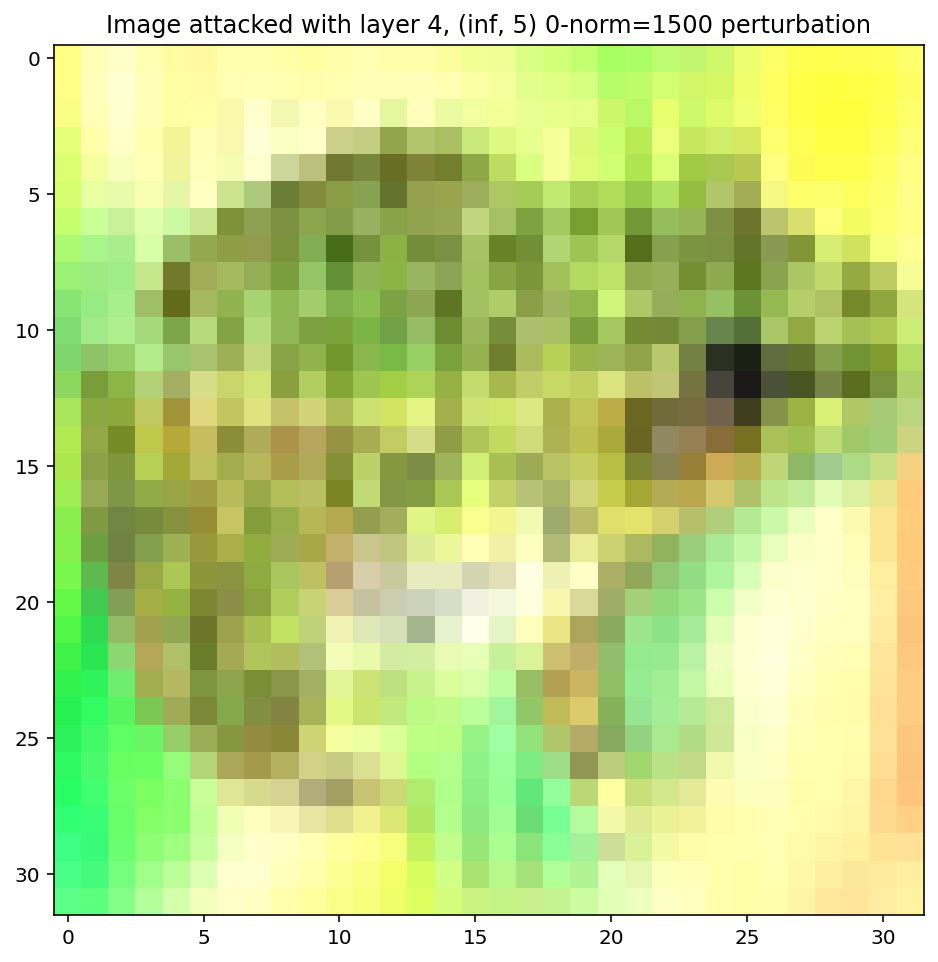

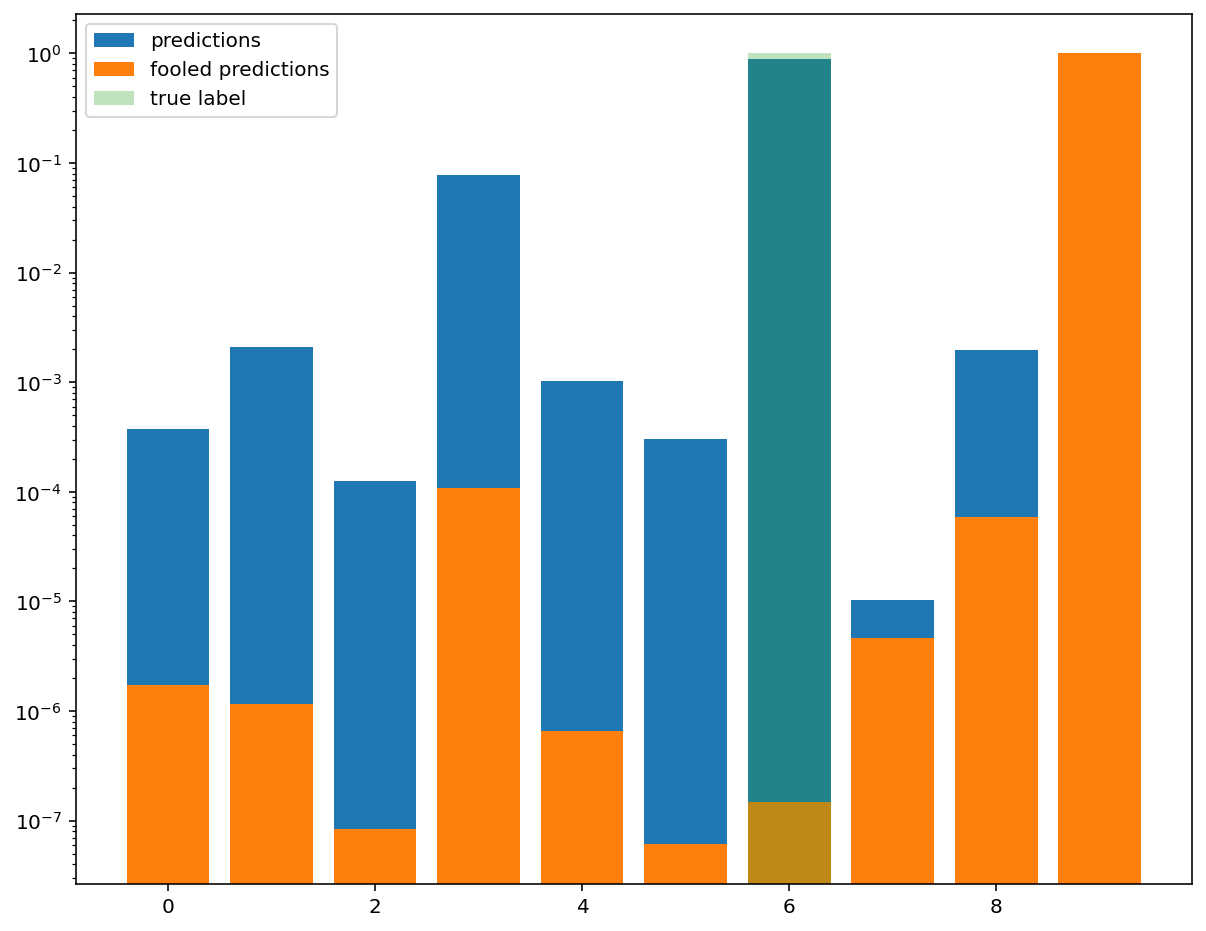

In [25]:
img = dataset[95][0].to(device)
label = dataset[95][1]
alpha = 0.1

plt.title(f"Image attacked with layer {i}, ({p}, {q}) 0-norm={k} perturbation")
plt.imshow((img + alpha * (0.5 + 0.5 * adv)).permute(1, 2, 0).detach().cpu().numpy())
plt.show()

preds = torch.softmax(model(img.unsqueeze(0)), -1).squeeze().detach().cpu().numpy()
preds_fooled = torch.softmax(model(img.unsqueeze(0) + alpha * (0.5 + 0.5 * adv)), -1).squeeze().detach().cpu().numpy()
plt.bar(np.arange(len(preds)), preds, label="predictions")
plt.bar(np.arange(len(preds)), preds_fooled, label="fooled predictions")
plt.bar(label, 1, alpha=0.3, label="true label")
plt.yscale("log")
plt.legend();

  0%|          | 0/100 [00:00<?, ?it/s]

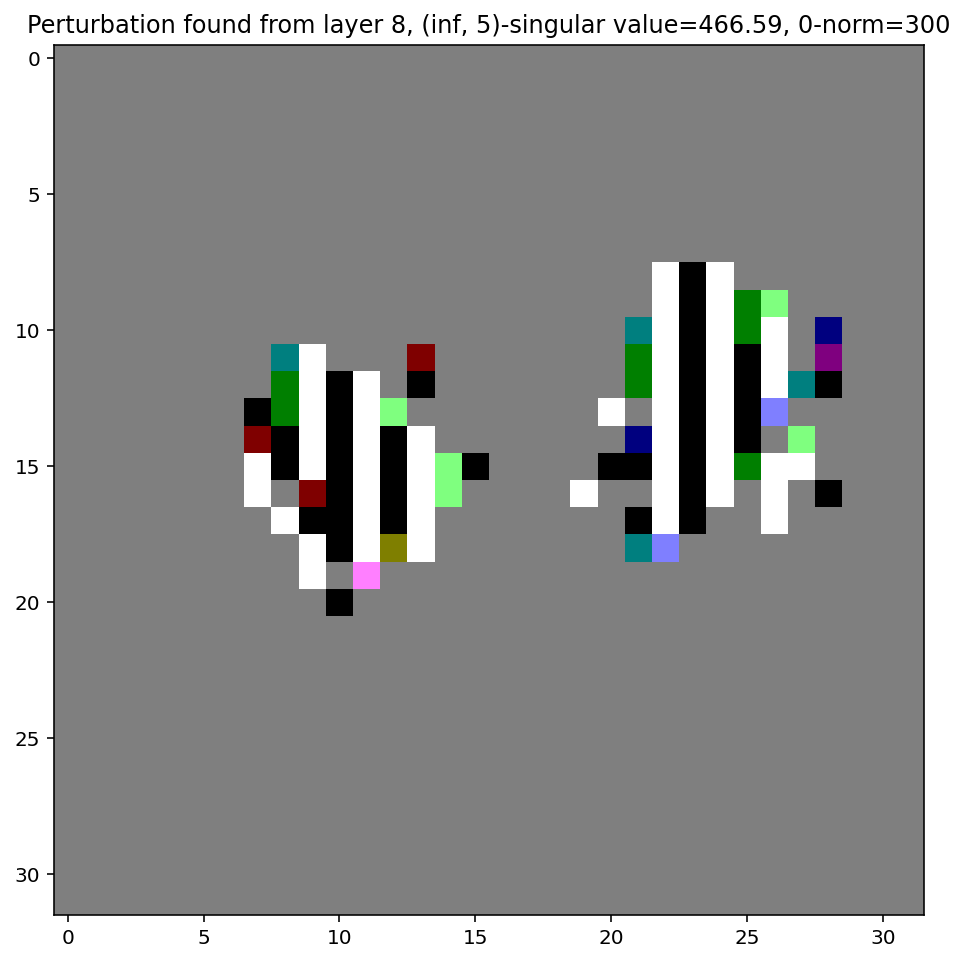

  0%|          | 0/100 [00:00<?, ?it/s]

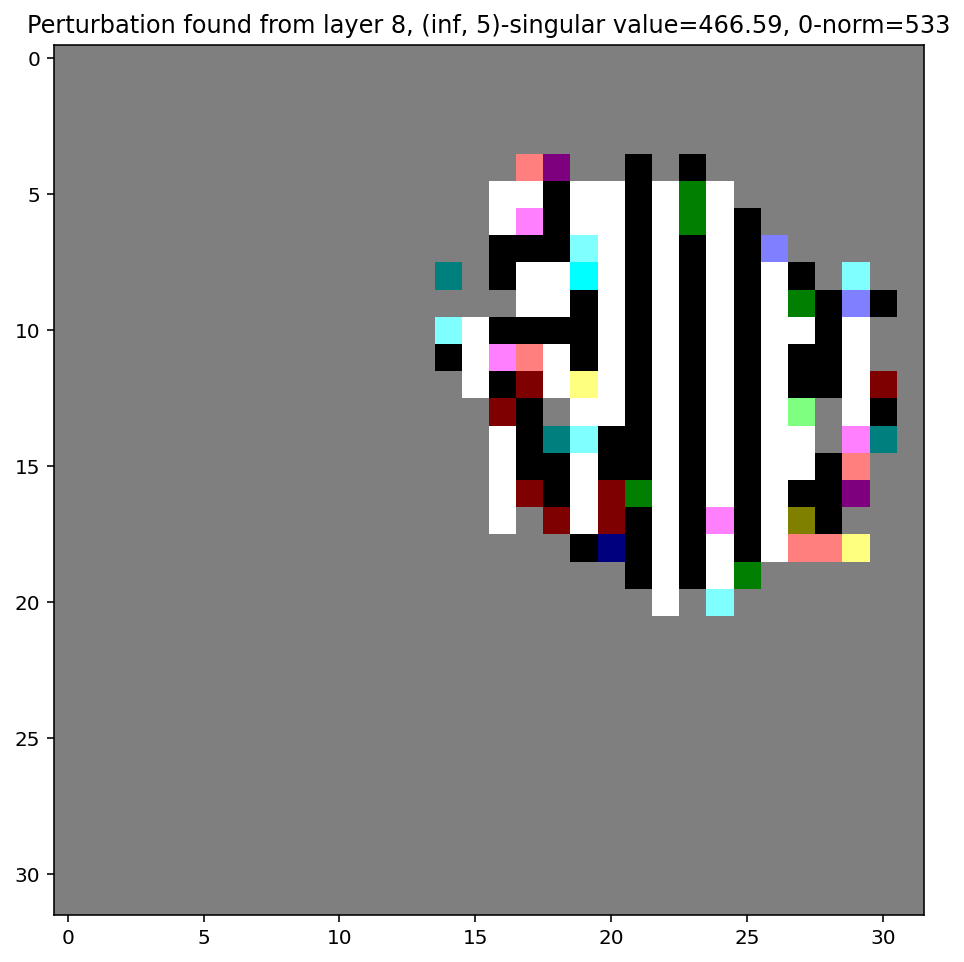

  0%|          | 0/100 [00:00<?, ?it/s]

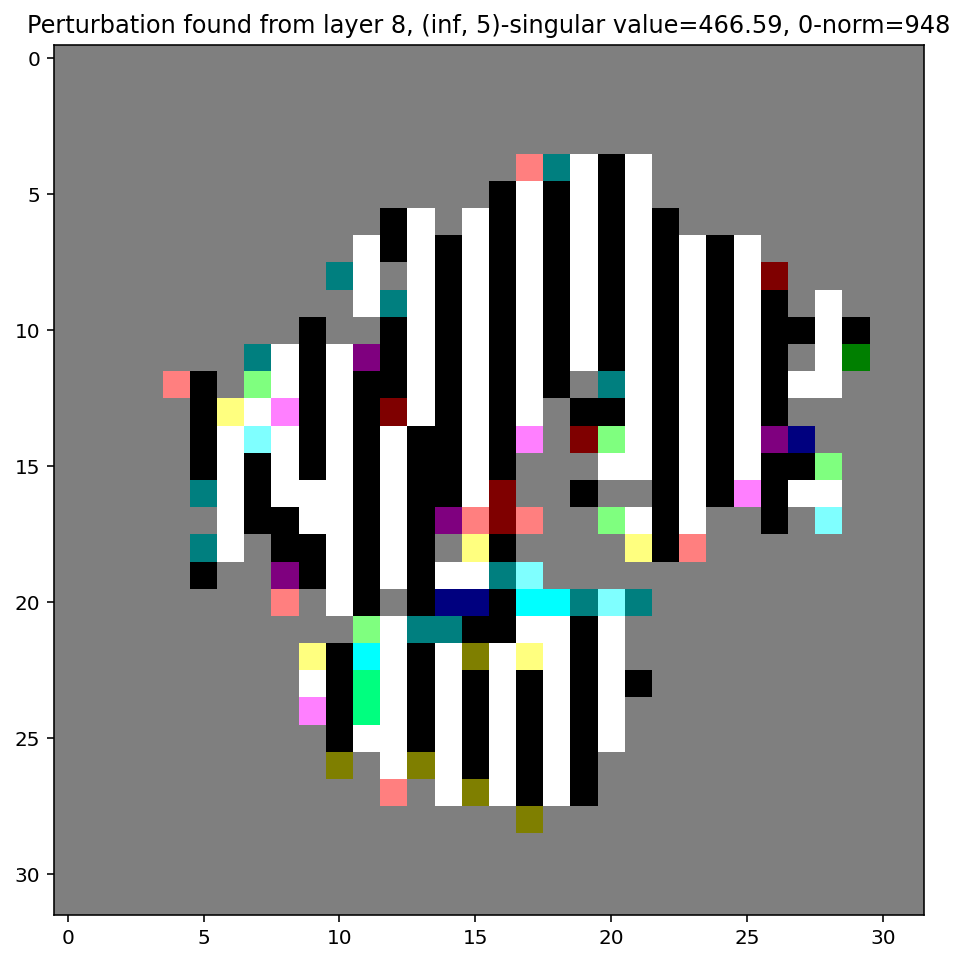

  0%|          | 0/100 [00:00<?, ?it/s]

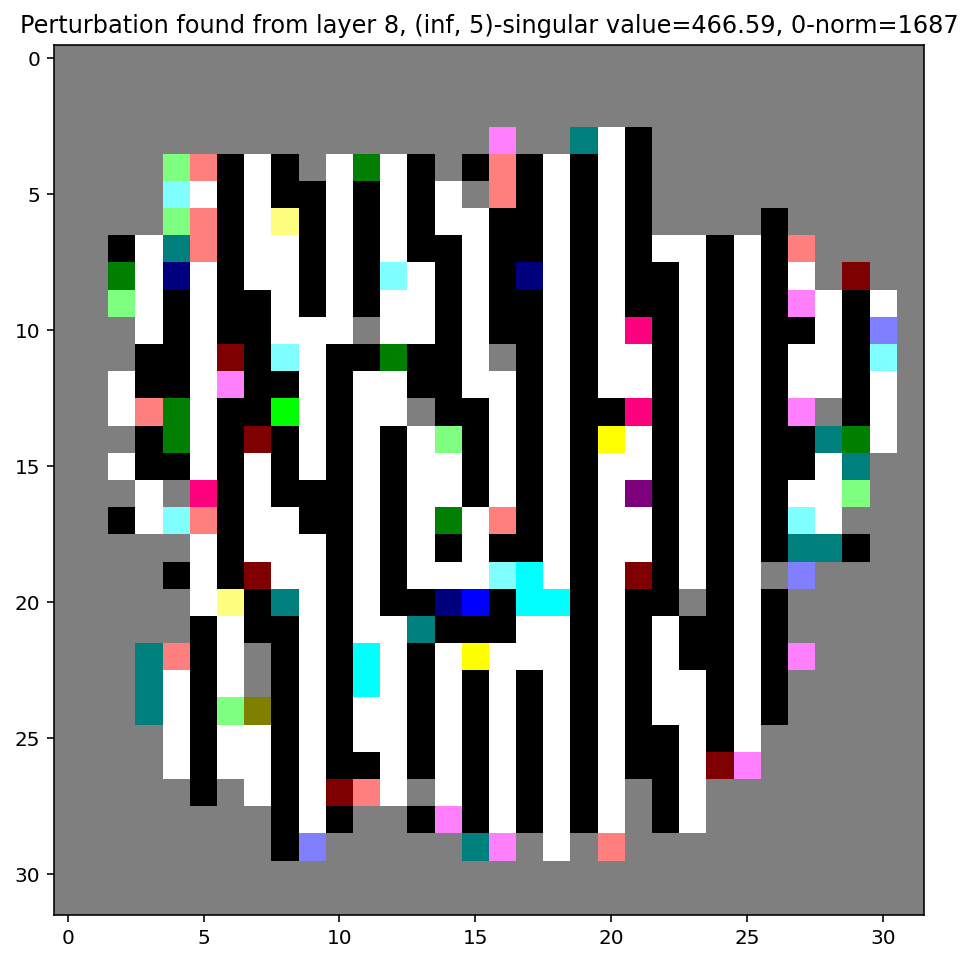

  0%|          | 0/100 [00:00<?, ?it/s]

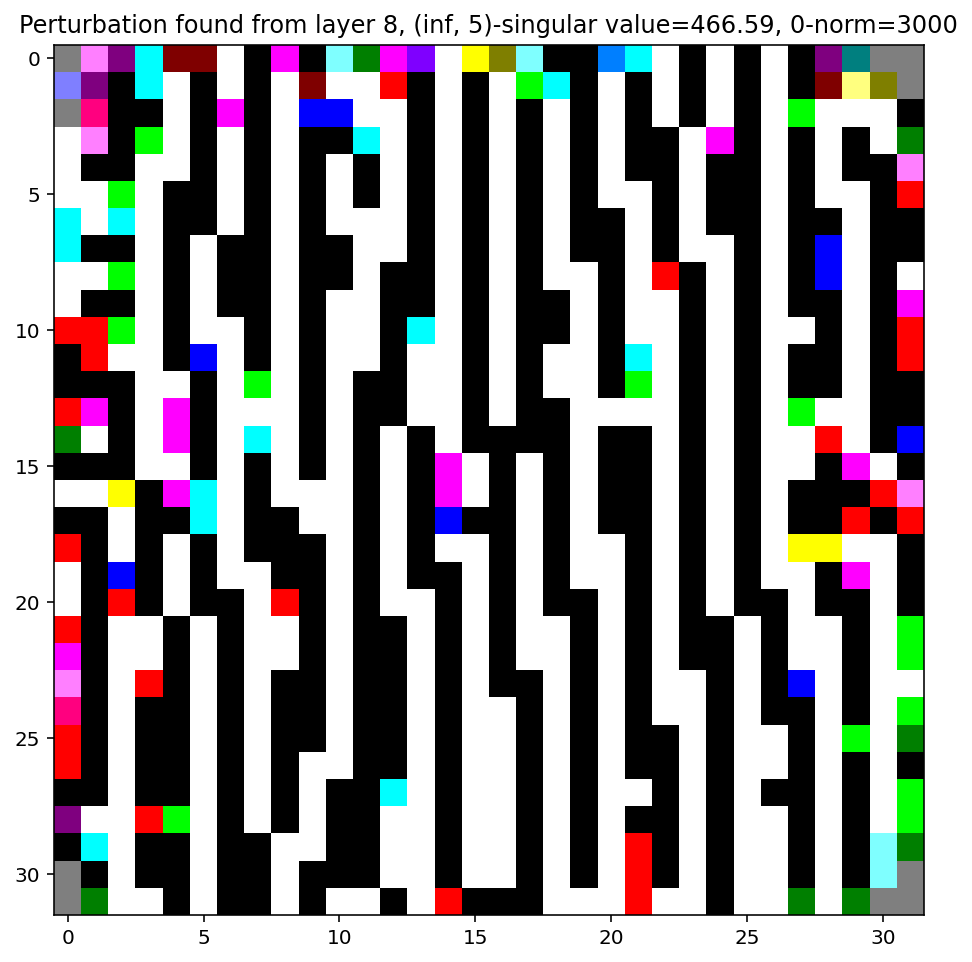

  0%|          | 0/100 [00:00<?, ?it/s]

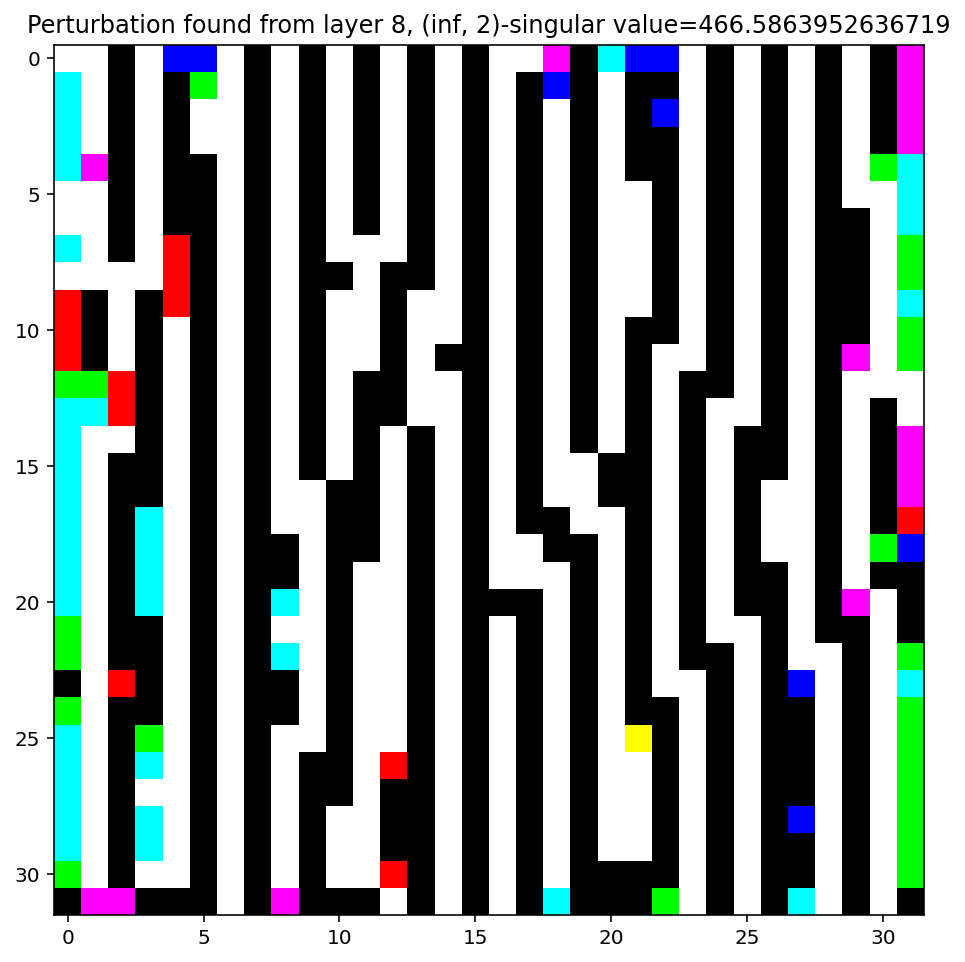

  0%|          | 0/100 [00:00<?, ?it/s]

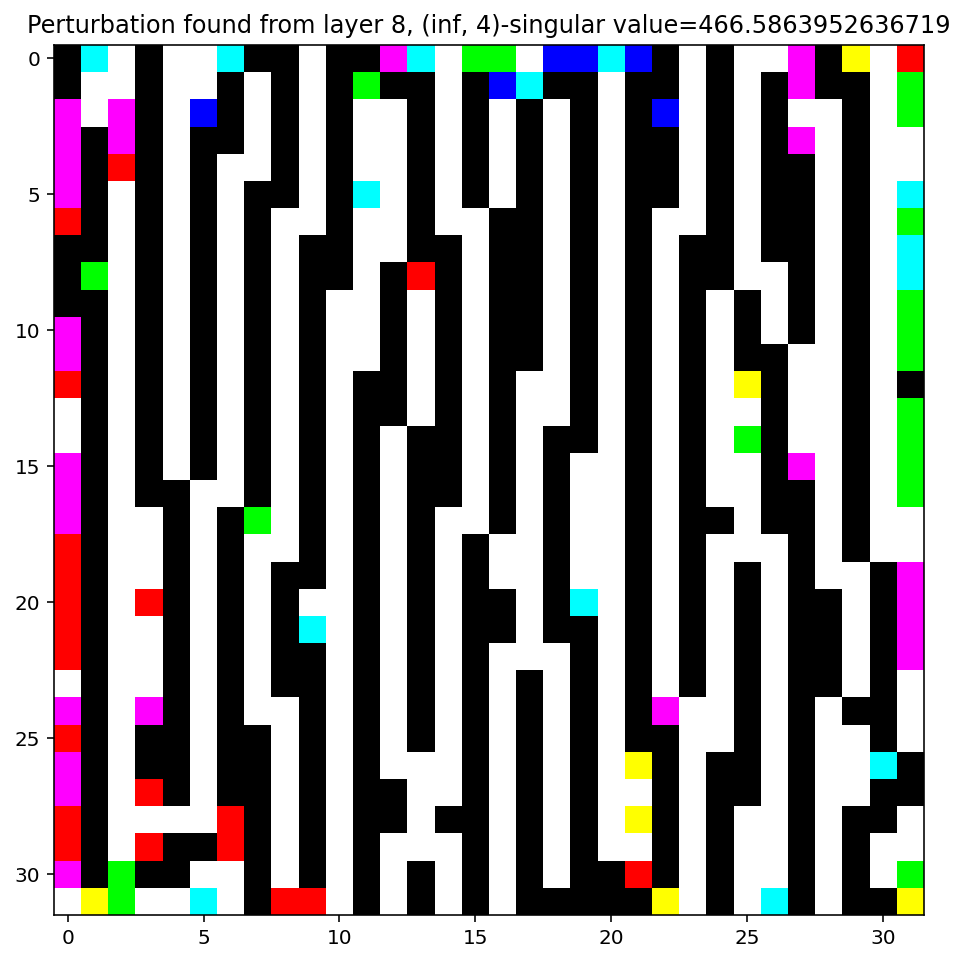

  0%|          | 0/100 [00:00<?, ?it/s]

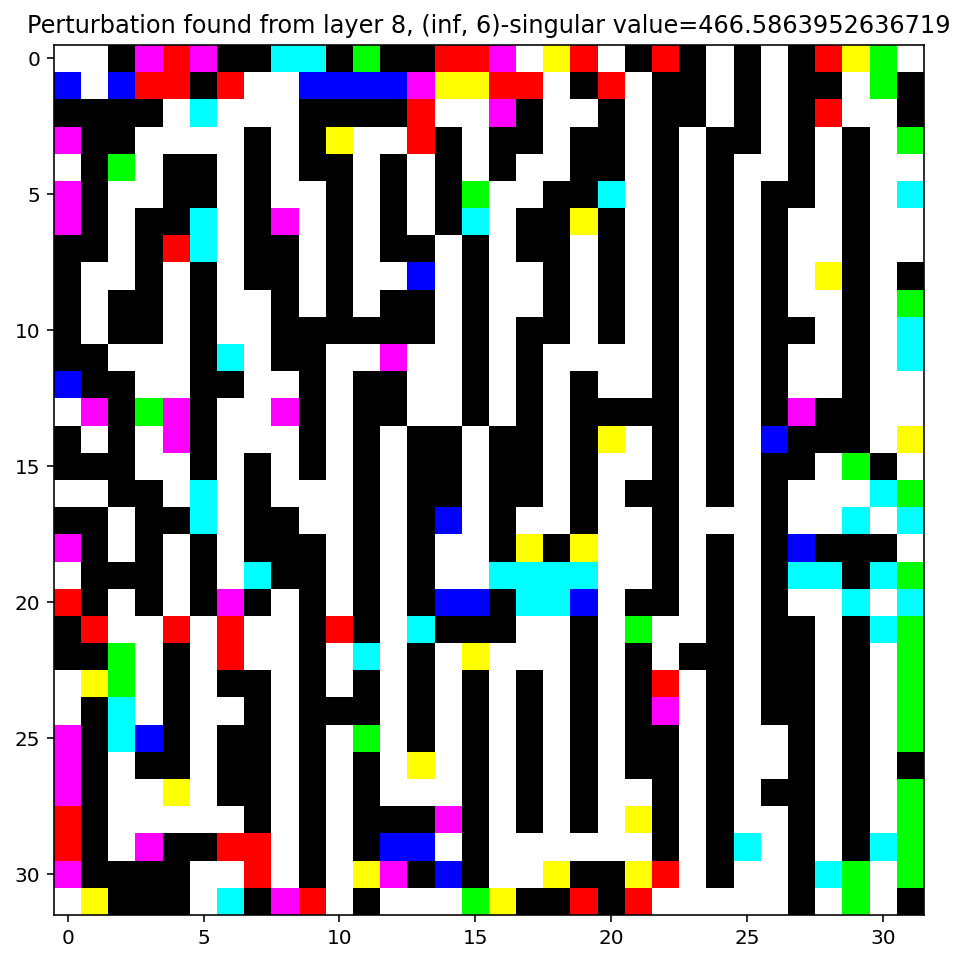

  0%|          | 0/100 [00:00<?, ?it/s]

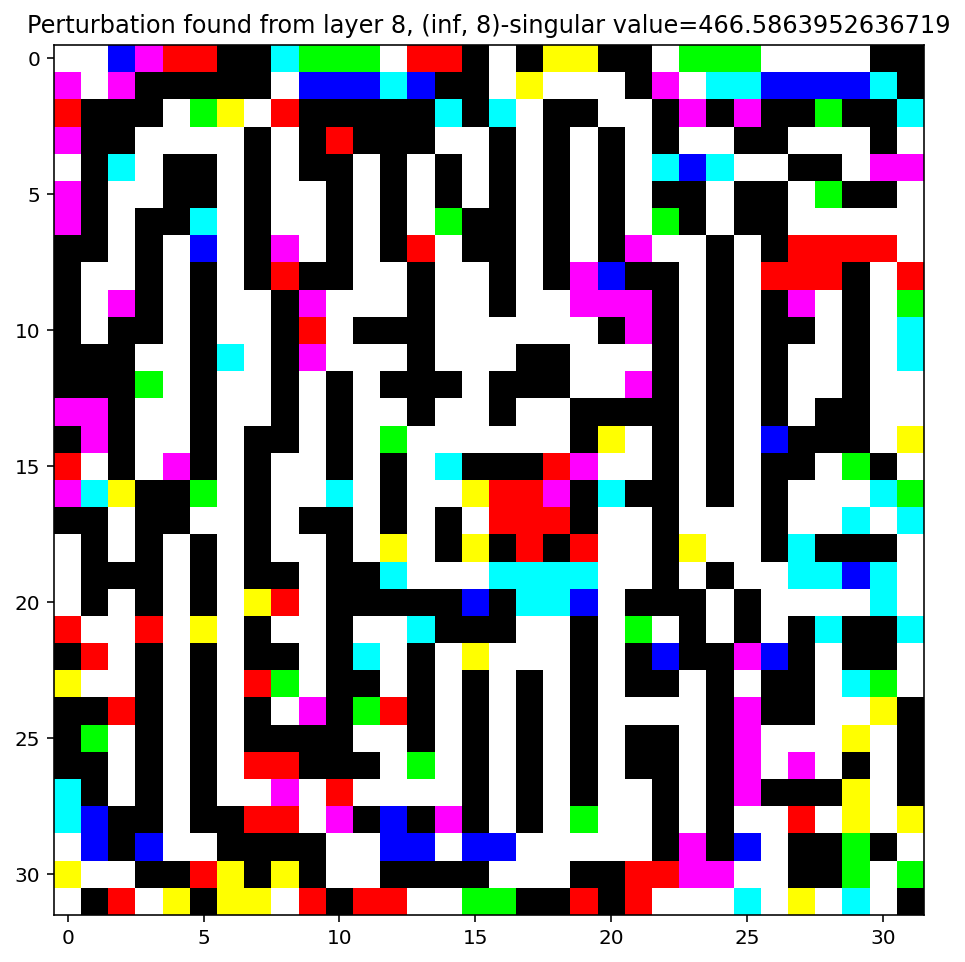

  0%|          | 0/100 [00:00<?, ?it/s]

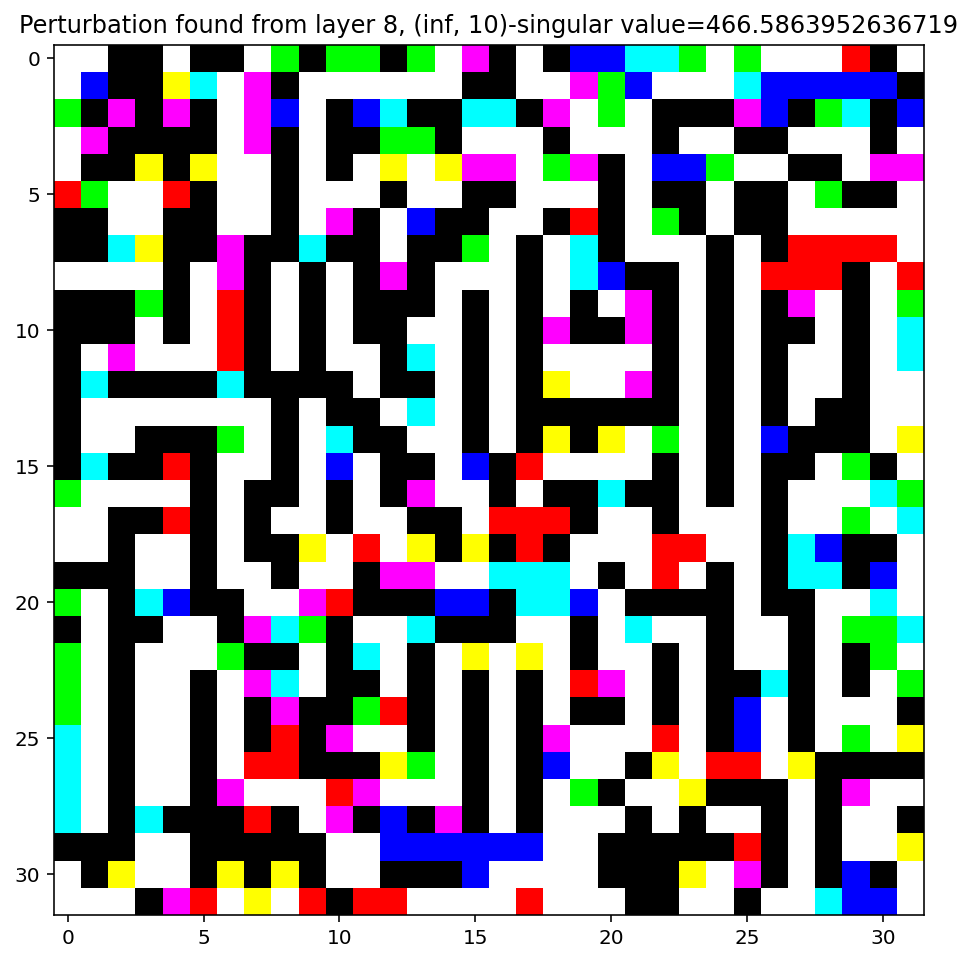

In [26]:
i = 8
p = np.inf

k_range = np.logspace(np.log10(300), np.log10(3000), 5).astype(int)
for k in k_range:
    adv, s = generate_universal_perturbation(imgs, lambda x: get_layer_output(x, model, i), 100, p, q, k)
    plt.title(f"Perturbation found from layer {i}, ({p}, {q})-singular value={perturb['s']:.2f}, 0-norm={k}")
    plt.imshow((0.5 + adv * 0.5).permute(1, 2, 0).detach().cpu().numpy())
    plt.show()

for q in range(2, 12, 2):
    adv, s = generate_universal_perturbation(imgs, lambda x: get_layer_output(x, model, i), 100, p, q)
    plt.title(f"Perturbation found from layer {i}, ({p}, {q})-singular value={perturb['s']}")
    plt.imshow((0.5 + adv * 0.5).permute(1, 2, 0).detach().cpu().numpy())
    plt.show()

In [27]:
perturbations = {}
p = np.inf
q = 8
k = 1500

for i in range(len(model.net)):
    adv, s = generate_universal_perturbation(imgs, lambda x: get_layer_output(x, model, i), 100, p, q, k)
    perturbations[i] = {"adv": adv, "s": s}

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [28]:
for index in tqdm(perturbations.keys()):
    perturbations[index]["rate"] = get_fooling_rate(model, dataloader, perturbations[index]["adv"])

  0%|          | 0/17 [00:00<?, ?it/s]

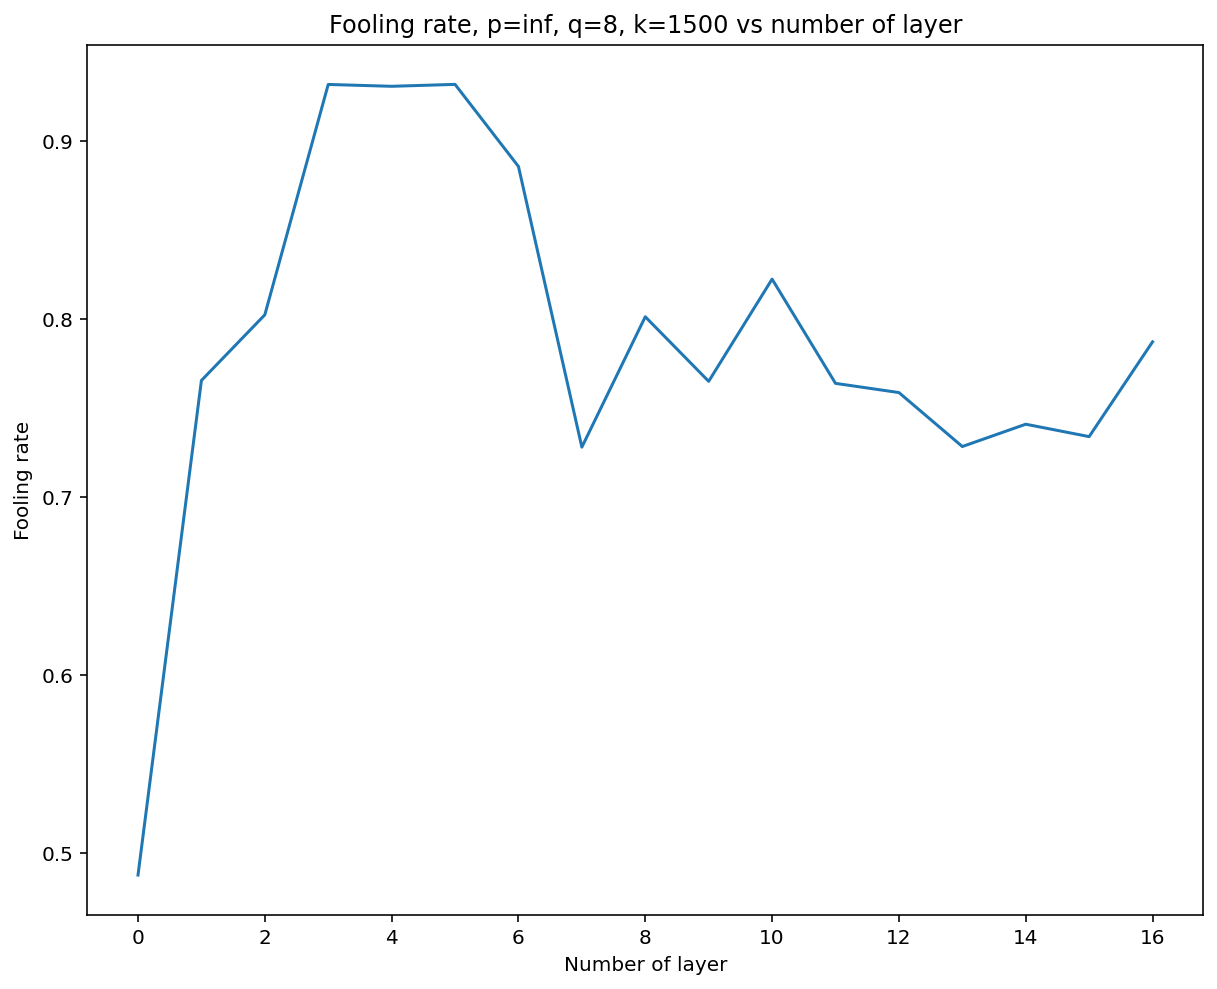

In [29]:
plt.title(f"Fooling rate, p=inf, q={q}, k={k} vs number of layer")
plt.xlabel("Number of layer")
plt.ylabel("Fooling rate")
plt.plot(rates)
plt.show()

[ 8 15 12 14 16  9 10 11 13  6  7  3  4  5  2  1  0]


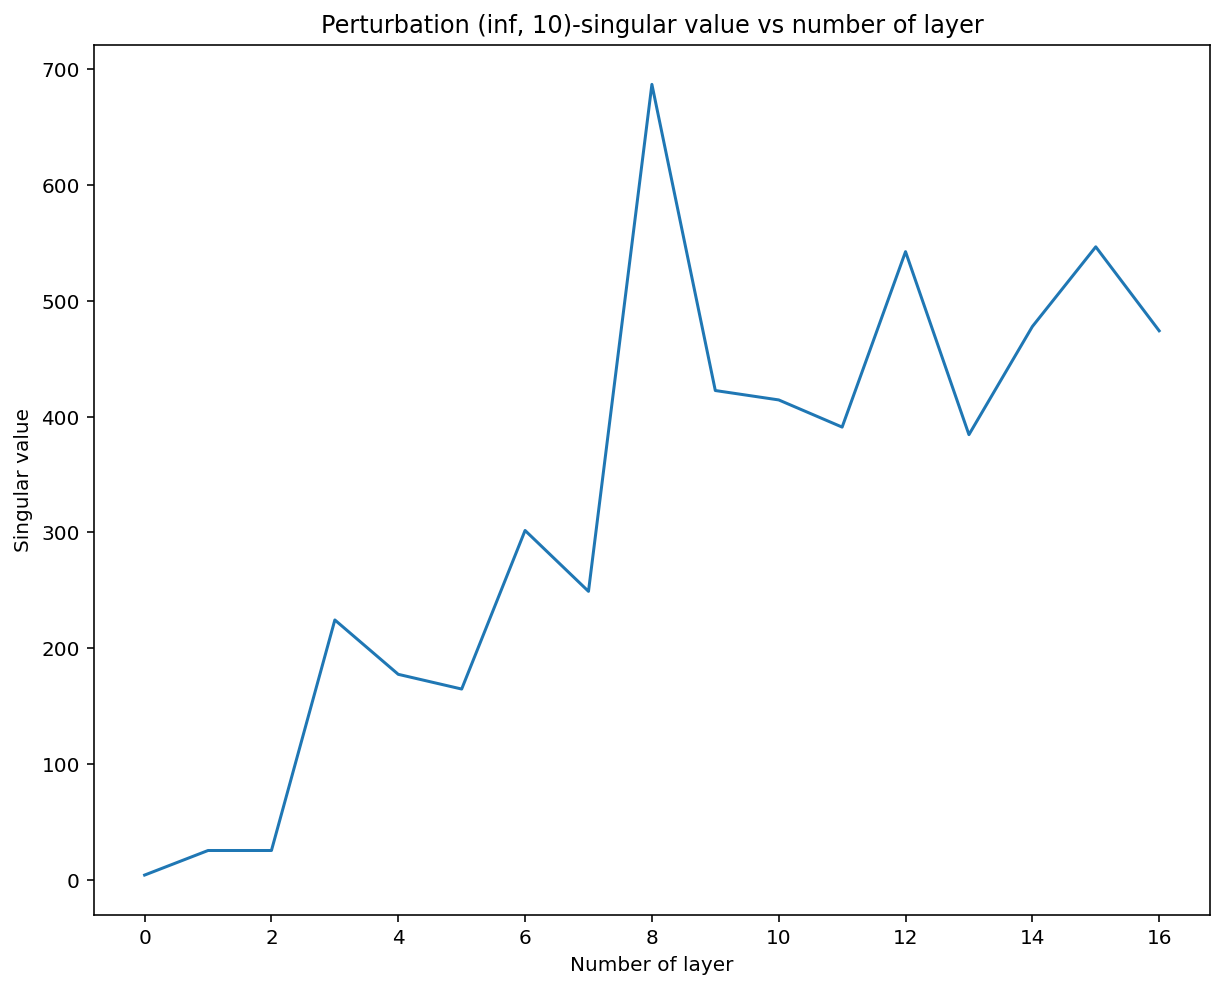

In [30]:
sigmas = [p["s"].detach().cpu().numpy() for i, p in sorted(perturbations.items())]
print(np.argsort(sigmas)[::-1])
plt.title(f"Perturbation (inf, 10)-singular value vs number of layer")
plt.xlabel("Number of layer")
plt.ylabel("Singular value")
plt.plot(sigmas)
plt.show()

As $p \to \infty$, pixels are squeezed to $[-1, 1]$ and more "clean" colors appear, such as yellow, purple, cyan black, white, red, green, blue.   

Larger $q$ seems to smoothen the problem so colors become more diverse, not only black and white, and lower $q$ produces more geometric than colorful patterns.   

Not surprisingly, smaller $k$ penalty leads to more pixels equal to $0$, producing gray colors.   

Deeper layers , no matter if solution is sparse, tend to have larger singular values associated with perturbation, prompting that more information can be disturbed in them, but highest fooling rate is achieved on first layers. Probably more careful hyperparameter tuning will produce better results for deeper layers.
